In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from skimage import io, transform
import matplotlib.image as mpimg
from PIL import Image
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import scipy
import random
import pickle
import scipy.io as sio
import torch.nn.init as I

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.ion()

from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from skimage import io
import torch
from torchvision import transforms
import torchvision
from skimage import color
from torch.optim import lr_scheduler
from torchvision.utils import make_grid
import nibabel

In [2]:
import pickle
def pickling(file,path):
    pickle.dump(file,open(path,'wb'))
def unpickling(path):
    file_return=pickle.load(open(path,'rb'))
    return file_return

In [3]:
available_segments = [   0,    2,    4,    5,    7,    8,   10,   11,   12,   13,   14,
         15,   16,   17,   18,   24,   26,   28,   30,   31,   41,   43,
         44,   46,   47,   49,   50,   51,   52,   53,   54,   58,   60,
         62,   63,   72,   77,   80,   85,  251,  252,  253,  254,  255,
       1000, 1001, 1002, 1003, 1005, 1006, 1007, 1008, 1009, 1010, 1011,
       1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022,
       1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033,
       1034, 1035, 2000, 2001, 2002, 2003, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031,
       2032, 2033, 2034, 2035, 3001, 3002, 3003, 3005, 3006, 3007, 3008,
       3009, 3010, 3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019,
       3020, 3021, 3022, 3023, 3024, 3025, 3026, 3027, 3028, 3029, 3030,
       3031, 3032, 3033, 3034, 3035, 4001, 4002, 4003, 4005, 4006, 4007,
       4008, 4009, 4010, 4011, 4012, 4013, 4014, 4015, 4016, 4017, 4018,
       4019, 4020, 4021, 4022, 4023, 4024, 4025, 4026, 4027, 4028, 4029,
       4030, 4031, 4032, 4033, 4034, 4035, 5001, 5002]

In [4]:
#rest_available = [4031,5001,5002,4022,4023,4024,4025,4029,4028]
# rest_available = [4027,4017,4008,3033,3024,3025,3027,3028,3029]
# wm-rh-rostralmiddlefrontal , wm-rh-paracentral     , wm-rh-inferiorparietal, wm-lh-temporalpole, wm-lh-precentral, wm-lh-precuneus,
# wm-lh-superiorfrontal,   wm-lh-rostralmiddlefrontal,  wm-lh-superiorparietal

In [5]:
rest_available = [2000, 2001, 2002, 2003, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031,
       2032, 2033, 2034, 2035]

In [59]:
rest_available = [2001,2002,2005,2008,2011,2018,2021,2022,2024,2025,2027,2028,2030,2031,2035]

In [6]:
rest_available = [2001,2002,2005,2008,2011,2022,2024,2025,2027,2028,2030,2035]

In [ ]:
Class 0 (DS): 0.8930
Class 1 (DS): 0.8828
Class 2 (DS): 0.8297
Class 3 (DS): 0.8519
Class 4 (DS): 0.8297
Class 5 (DS): 0.6975
Class 6 (DS): 0.7420
Class 7 (DS): 0.8584
Class 8 (DS): 0.8635
Class 9 (DS): 0.8102
Class 10 (DS): 0.8154
Class 11 (DS): 0.8659
Class 12 (DS): 0.8330
Class 13 (DS): 0.5980
Class 14 (DS): 0.9050

In [7]:
num_seg = len(rest_available)+1

In [8]:
num_seg

13

In [9]:
x_coordinate = np.zeros((256,256))
for i in range(256):
    x_coordinate[i:] = [i]*256    
y_coordinate = x_coordinate.copy()
y_coordinate = y_coordinate.T

In [10]:
x_coordinate = x_coordinate/255
y_coordinate = y_coordinate/255

In [11]:
class BrainImages(Dataset):
    def __init__(self, image_dir, label_dir, train_data = False, flipping = True, rotation = True, translation = True, \
                 coord = True):
        
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.flipping = flipping
        self.rotation = rotation
        self.translation = translation
        self.train_data = train_data
        self.coord = coord

    def __len__(self):
        return len(self.image_dir)

    def __getitem__(self,idx):
        image_path = "/gpfs/data/"+self.image_dir[idx]
        aseg_path = "/gpfs/data/"+self.label_dir[idx]
        
        img_orig = nibabel.freesurfer.mghformat.MGHImage.from_filename(image_path)
        image = img_orig.get_data().astype(np.float64)
        aseg_img = nibabel.freesurfer.mghformat.MGHImage.from_filename(aseg_path)
        aseg_img = aseg_img.get_data().astype(np.float64)

        flip = random.random() > 0.5
        angle = random.uniform(-5,5)
        dx = np.round(random.uniform(-10,10))
        dy = np.round(random.uniform(-10,10))
        
        im = Image.fromarray(image[0])
        target = Image.fromarray(aseg_img[0])
        if self.train_data:
            if self.flipping and flip:
                im = im.transpose(0)
                target = target.transpose(0)
            if self.rotation:
                im = im.rotate(angle)
                target = target.rotate(angle)
            if self.translation:
                im = im.transform((256,256),0, (1,0,dx,0,1,dy))
                target = target.transform((256,256),0,(1,0,dx,0,1,dy))
                
        im = np.array(im, np.float64, copy=False)
        min_im = np.min(im)
        max_im = np.max(im)
        im = (im - min_im)/(max_im - min_im)
        if self.coord:
            im = np.array([im, x_coordinate, y_coordinate], np.float64, copy=False)
            im = torch.from_numpy(im).type(torch.FloatTensor)
        else:
            im = torch.from_numpy(im).type(torch.FloatTensor).unsqueeze(0)

        target = np.array(target, np.float64, copy=False)
        target_label = np.zeros((len(rest_available)+1,256,256))
        for i,a in enumerate(available_segments):
            temp = (target==a).astype(int)
            if a in rest_available:
                target_label[rest_available.index(a),:,:] = temp
            else:
                target_label[len(rest_available),:,:] = target_label[len(rest_available),:,:] + temp
        target_label[len(rest_available),:,:] = (target_label[len(rest_available),:,:]>=1).astype(int) 
        target_label = torch.from_numpy(target_label).type(torch.FloatTensor)
        sample = {'x':im,'y':target_label} 
        return sample

In [12]:
file_names = pd.read_csv("wmparc_complete_path.csv")

In [13]:
train_subjects = unpickling("wmparc_train_index")
val_subjects = unpickling("wmparc_val_index")
test_subjects = unpickling("wmparc_test_index")

In [14]:
full_train_raw = list(file_names.iloc[train_subjects,2])
full_train_seg = list(file_names.iloc[train_subjects,3])

full_val_raw = list(file_names.iloc[val_subjects,2])
full_val_seg = list(file_names.iloc[val_subjects,3])

full_test_raw = list(file_names.iloc[test_subjects,2])
full_test_seg = list(file_names.iloc[test_subjects,3])

In [15]:
file_names.head()

,left_to_right_raw,left_to_right_segmented,top_to_bottom_raw,top_to_bottom_segmented,back_to_front_raw,back_to_front_segmented
0,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...
1,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...
2,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...
3,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...
4,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...


In [16]:
rand1 = np.arange(len(full_train_raw))
np.random.shuffle(rand1)
rand1 = rand1[:3000]

rand2 = np.arange(len(val_subjects))
np.random.shuffle(rand2)
rand2 = rand2[:1000]

rand3 = np.arange(len(test_subjects))
np.random.shuffle(rand3)
rand3 = rand3[:3]

In [17]:
cd = True
transformed_dataset = {'train': BrainImages(np.array(full_train_raw)[rand1],np.array(full_train_seg)[rand1], train_data= True, flipping=False, coord = cd),
                       'validate': BrainImages(np.array(full_val_raw)[rand2],np.array(full_val_seg)[rand2], coord = cd),
                       'test': BrainImages(np.array(full_test_raw)[rand3],np.array(full_test_seg)[rand3], coord = cd)
                                               }
bs = 40
dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs,
                        shuffle=True, num_workers=0) for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}

In [18]:
data = next(iter(dataloader['train']))

In [19]:
data['x'].size()

torch.Size([40, 3, 256, 256])

In [20]:
data['y'].size()

torch.Size([40, 13, 256, 256])

In [21]:
num_seg

13

In [22]:
list_arr = []
for data in dataloader["train"]:
    y = data['y'].numpy()
    N,C,_,_ = y.shape
    sum_arr = np.sum(y.reshape(N,C,-1),axis = 2)
    list_arr.append(sum_arr)
final_arr = np.concatenate(list_arr,axis = 0)
pickling(final_arr,'wt_13_try5.p')

In [23]:
final_arr = unpickling('wt_13_try5.p')

In [24]:
final_arr.shape

(3000, 13)

In [25]:
class Downsample_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self,x):
        x = F.relu(self.bn1(self.conv1(x)))
        y = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(y, 2,stride = 2)
        
        return x, y

In [26]:
class Upsample_block(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(Upsample_block, self).__init__()
        self.transconv = nn.ConvTranspose2d(in_channels, out_channels, 4, padding = 1, stride = 2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self,x, y):
        x = self.transconv(x)
        x = torch.cat((x,y),dim = 1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        
        return x

In [27]:
class Unet(nn.Module):
    def __init__(self,in_chan = 3, out_chan = 3):
        super(Unet, self).__init__()
        self.down1 = Downsample_block(in_chan,64)
        self.down2 = Downsample_block(64,128)
        self.down3 = Downsample_block(128,256)
        self.down4 = Downsample_block(256,512)
        self.conv1 = nn.Conv2d(512,1024, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(1024)
        self.conv2 = nn.Conv2d(1024,1024,3, padding = 1)
        self.bn2 = nn.BatchNorm2d(1024)
        self.up4 = Upsample_block(1024,512)
        self.up3 = Upsample_block(512,256)
        self.up2 = Upsample_block(256,128)
        self.up1 = Upsample_block(128,64)
        self.outconv = nn.Conv2d(64,out_chan, 1)
        
    def forward(self,x):
        x, y1 = self.down1(x)
        x, y2 = self.down2(x)
        x, y3 = self.down3(x)
        x, y4 = self.down4(x)
        x = F.dropout2d(F.relu(self.bn1(self.conv1(x))))
        x = F.dropout2d(F.relu(self.bn2(self.conv2(x))))
        x = self.up4(x, y4)
        x = self.up3(x, y3)
        x = self.up2(x, y2)
        x = self.up1(x, y1)
        x = self.outconv(x)
        
        return x

In [28]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        I.xavier_normal(m.weight.data)

In [29]:
mask = (final_arr[:,-1]!=(256.0 *256.0))

In [30]:
wts_num = np.mean(final_arr[mask,:],axis=0)

In [31]:
wts_num

array([2.65079365e+01, 2.20593147e+01, 3.04820385e+01, 1.45581451e+02,
       1.15436928e+02, 9.42731857e+01, 1.40360901e+02, 1.02543861e+02,
       1.67278198e+02, 2.24554718e+02, 1.20811195e+02, 7.01269836e+01,
       6.42759570e+04], dtype=float32)

In [32]:
wts = []
for i in range(final_arr.shape[1] - 1):
    temp_mask = final_arr[:,i]!= 0
    temp_wt = np.mean(final_arr[temp_mask,i])
    wts.append(temp_wt)
zero_wt = 256.0 * 256.0 - np.sum(wts)
wts.append(zero_wt)
wts_num = np.array(wts)

In [33]:
wts_num

array([  122.98449707,    82.00310516,    96.27176666,   310.07296753,
         280.27990723,   148.28515625,   203.65090942,   166.32113647,
         282.01690674,   328.59658813,   235.13983154,   165.24015808,
       63115.13720703])

In [34]:
wts_torch = Variable(torch.from_numpy(np.array(wts_num))).cuda()

In [35]:
def dice_loss_2(true,scores,mean, epsilon = 1e-4,p = 2):
    N, C, sh1, sh2 = true.size()
    
    
    preds = F.softmax(scores, dim = 1)
    true = true.view(N, C, -1)
    preds = preds.view(N, C, -1)
    wts = torch.sum(true, dim = 2) + epsilon
    mean = 1/torch.pow(mean,p)
    wts[:,:] = mean[None].repeat(N,1)
    wts = wts/(torch.sum(wts,dim = 1)[:,None])
    prod = torch.sum(true*preds,dim = 2)
    sum_tnp = torch.sum(true + preds, dim = 2)
    num = torch.sum(wts * prod, dim = 1)
    denom = torch.sum(wts * sum_tnp, dim = 1) + epsilon
    loss = 1 - 2*(num/denom)
    return torch.mean(loss)

In [36]:
def dice_score(true,scores, epsilon = 1e-7):
    N, C, sh1, sh2 = true.size()
    
    true = true.view(N,C,-1)
    preds = F.softmax(scores, dim = 1)
    pred_class = (torch.max(preds, dim = 1)[1]).view(N,-1)
    class_score = [0]*C
    for i in range(C):
        class_score[i] = (pred_class == i).data.type(torch.cuda.FloatTensor)
    true = true.data.type(torch.cuda.FloatTensor)
    def numerator(truth,pred, idx):
        return(torch.sum(truth[:,idx,:] * pred,dim = 1)) + epsilon/2
    def denominator(truth,pred,idx):
        return(torch.sum(truth[:,idx,:]+pred,dim = 1)) + epsilon
    dice_class_score = [0]*C
    for i in range(C):
        dice_class_score[i] = torch.mean(2*(numerator(true,class_score[i],i))/(denominator(true,class_score[i],i)))
    return dice_class_score
    

In [37]:
import time
def train_model(model, optimizer,dataloader, name,num_seg = 3, num_epochs = 100, verbose = False, every = 1,\
                print_all_ds = True):
    since = time.time()
    best_loss = np.inf
    best_score = 0
    loss_hist = {'train':[],'validate':[]}
    dice_scores_of_all_class = [{'train':[],'validate':[]} for i in range(num_seg)]    
    for i in range(num_epochs):
        for phase in ['train', 'validate']:
            running_loss = 0
            run_class_scores = [0]*num_seg
            running_total = 0
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)
    
            for data in dataloader[phase]:
                optimizer.zero_grad()
                x = data['x']
                y = data['y']
                x = Variable(x).cuda()
                y = Variable(y).cuda()
                N, C, sh1, sh2 = y.size()
                y_mask = (torch.sum(y[:,:(C-1),:,:].contiguous().view(N,-1),dim = 1) != 0)
                y = y[y_mask]
                x = x[y_mask]
                try:
                    output = model(x)
                except:
                    continue
                loss = dice_loss_2(y, output,wts_torch)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                running_loss += loss.data[0] * N
                running_total += N
                dice_score_batch = dice_score(y,output)
                for j in range(num_seg):
                    run_class_scores[j] += dice_score_batch[j] * N
            epoch_loss = running_loss/running_total
            loss_hist[phase].append(epoch_loss.item())
            epoch_score = 0
            for j in range(num_seg):
                score = run_class_scores[j]/running_total
                dice_scores_of_all_class[j][phase].append(score.item())
                if j < num_seg - 1:
                    epoch_score += score.item()
            epoch_score_av = epoch_score/ (num_seg - 1)
            if verbose or i%every == 0:
                print('Epoch: {}, Phase: {}, epoch loss: {:.4f}, Av. Dice Score: {:.4f}'\
                      .format(i,phase,epoch_loss,epoch_score_av))
                if print_all_ds:
                    for j in range(num_seg - 1):
                        print('Class {} (DS): {:.4f}'.format(j,dice_scores_of_all_class[j][phase][-1]))
                print('-'*10)
            
        if phase == 'validate' and epoch_score_av > best_score:
            best_loss = epoch_loss
            best_score = epoch_score_av
            best_model_wts = model.state_dict()
            torch.save(model,name)
    print('-'*50)    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val dice loss: {:4f}, Best Average DS: {:4f}'.format(best_loss,best_score))
    
    model.load_state_dict(best_model_wts)
    
    return model, loss_hist, dice_scores_of_all_class

In [38]:
model = Unet(in_chan = 3,out_chan = num_seg).cuda()
model.apply(weights_init)
model = nn.DataParallel(model)
criterion = dice_loss_2
#scheduler = lr_scheduler.StepLR(optimizer,step_size = 15)

In [39]:
torch.cuda.device_count()

3

In [51]:
optimizer = optim.Adam(model.parameters(),lr = 5e-5)

In [52]:
model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,'13seg_try5_3',num_seg = num_seg, num_epochs = 15,\
                                         every = 1, print_all_ds = True)

Epoch: 0, Phase: train, epoch loss: 0.1676, Av. Dice Score: 0.8892
Class 0 (DS): 0.9291
Class 1 (DS): 0.9154
Class 2 (DS): 0.8852
Class 3 (DS): 0.8661
Class 4 (DS): 0.8837
Class 5 (DS): 0.8941
Class 6 (DS): 0.8970
Class 7 (DS): 0.8683
Class 8 (DS): 0.8729
Class 9 (DS): 0.8713
Class 10 (DS): 0.8800
Class 11 (DS): 0.9072
----------
Epoch: 0, Phase: validate, epoch loss: 0.2156, Av. Dice Score: 0.8650
Class 0 (DS): 0.8833
Class 1 (DS): 0.8690
Class 2 (DS): 0.8457
Class 3 (DS): 0.8541
Class 4 (DS): 0.8440
Class 5 (DS): 0.8769
Class 6 (DS): 0.8892
Class 7 (DS): 0.8478
Class 8 (DS): 0.8569
Class 9 (DS): 0.8807
Class 10 (DS): 0.8297
Class 11 (DS): 0.9022
----------
Epoch: 1, Phase: train, epoch loss: 0.1626, Av. Dice Score: 0.8898
Class 0 (DS): 0.9275
Class 1 (DS): 0.9163
Class 2 (DS): 0.8880
Class 3 (DS): 0.8702
Class 4 (DS): 0.8798
Class 5 (DS): 0.8938
Class 6 (DS): 0.8939
Class 7 (DS): 0.8691
Class 8 (DS): 0.8747
Class 9 (DS): 0.8711
Class 10 (DS): 0.8844
Class 11 (DS): 0.9082
----------
E

Epoch: 12, Phase: validate, epoch loss: 0.2155, Av. Dice Score: 0.8666
Class 0 (DS): 0.8883
Class 1 (DS): 0.8697
Class 2 (DS): 0.8303
Class 3 (DS): 0.8519
Class 4 (DS): 0.8452
Class 5 (DS): 0.8802
Class 6 (DS): 0.8918
Class 7 (DS): 0.8493
Class 8 (DS): 0.8575
Class 9 (DS): 0.8836
Class 10 (DS): 0.8463
Class 11 (DS): 0.9052
----------
Epoch: 13, Phase: train, epoch loss: 0.1458, Av. Dice Score: 0.8988
Class 0 (DS): 0.9382
Class 1 (DS): 0.9210
Class 2 (DS): 0.8989
Class 3 (DS): 0.8752
Class 4 (DS): 0.8940
Class 5 (DS): 0.9019
Class 6 (DS): 0.9024
Class 7 (DS): 0.8814
Class 8 (DS): 0.8843
Class 9 (DS): 0.8796
Class 10 (DS): 0.8984
Class 11 (DS): 0.9099
----------
Epoch: 13, Phase: validate, epoch loss: 0.2132, Av. Dice Score: 0.8698
Class 0 (DS): 0.9018
Class 1 (DS): 0.8700
Class 2 (DS): 0.8345
Class 3 (DS): 0.8597
Class 4 (DS): 0.8480
Class 5 (DS): 0.8871
Class 6 (DS): 0.8945
Class 7 (DS): 0.8514
Class 8 (DS): 0.8527
Class 9 (DS): 0.8877
Class 10 (DS): 0.8478
Class 11 (DS): 0.9021
------

In [53]:
pickling(loss_hist, 'Loss_hist_13seg_try5_4.p')
pickling(dice_hist, 'Dice_hist_13seg_try5_4.p')

In [ ]:
# model = torch.load('29_seg_model_1')

In [54]:
def visualize1(image):
    p = F.softmax(image,dim = 0)
    p_maxim = torch.max(p, dim=0)[1]
    img = []
    for seg in range(num_seg):
        masked = (p_maxim==seg).data.type(torch.cuda.FloatTensor)
        img.append(masked)
    return torch.stack(img).unsqueeze(1).cpu()

In [55]:
%matplotlib inline
def show(img):    
    npimg = img.numpy()
    plt.figure(figsize = (20,20))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()

In [56]:
def visualize_few():
    data = next(iter(dataloader["validate"]))
    model.train(False)
    x = data['x']
    y = data['y']
    x = Variable(x).cuda()
    y = Variable(y).cuda()
                
    output = model(x)
    for i in range(bs):
        print('-'*100)
        print('Ground Truth')
        abc = data['y'][i,:,:,:]
        bcd = abc.unsqueeze(1)
        show(make_grid(bcd,padding=10,pad_value=1)) 
        print('-'*100)
        print('Prediction')
        show(make_grid(visualize1(output[i,:,:,:]),padding=10,pad_value=1))

----------------------------------------------------------------------------------------------------
Ground Truth


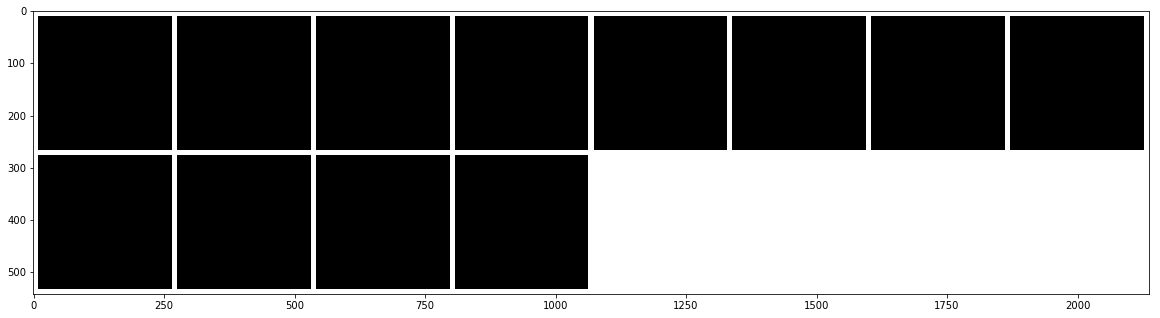

----------------------------------------------------------------------------------------------------
Prediction


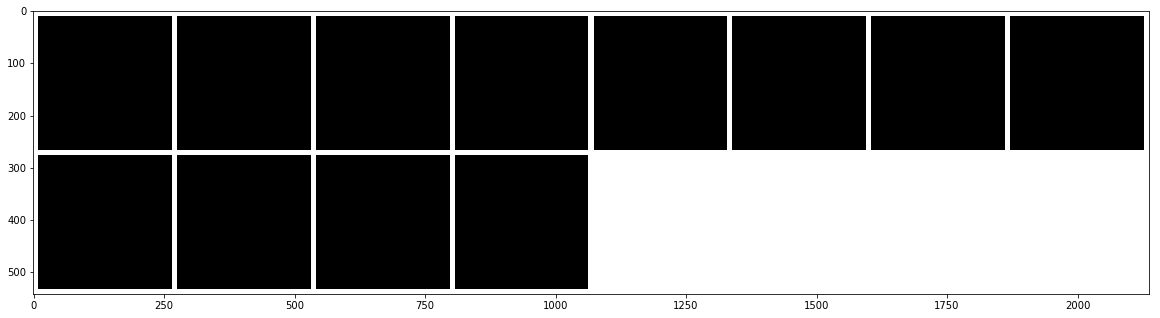

----------------------------------------------------------------------------------------------------
Ground Truth


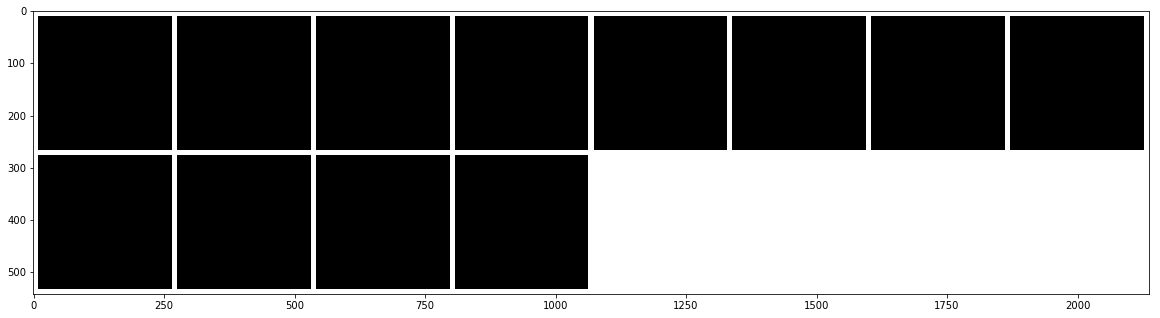

----------------------------------------------------------------------------------------------------
Prediction


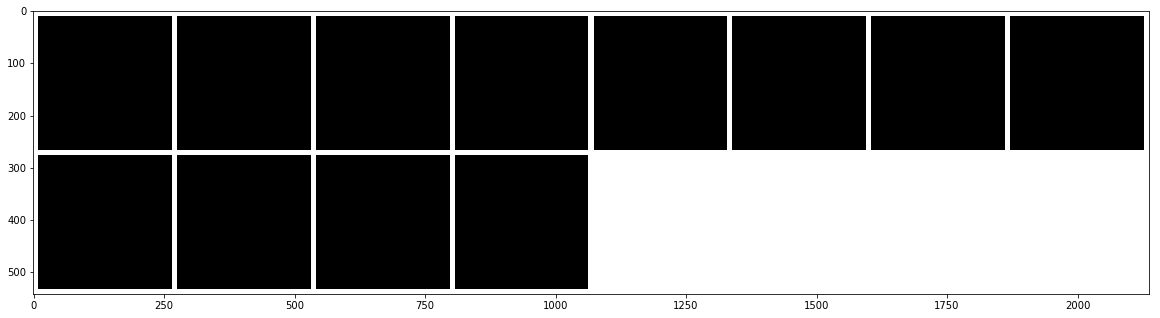

----------------------------------------------------------------------------------------------------
Ground Truth


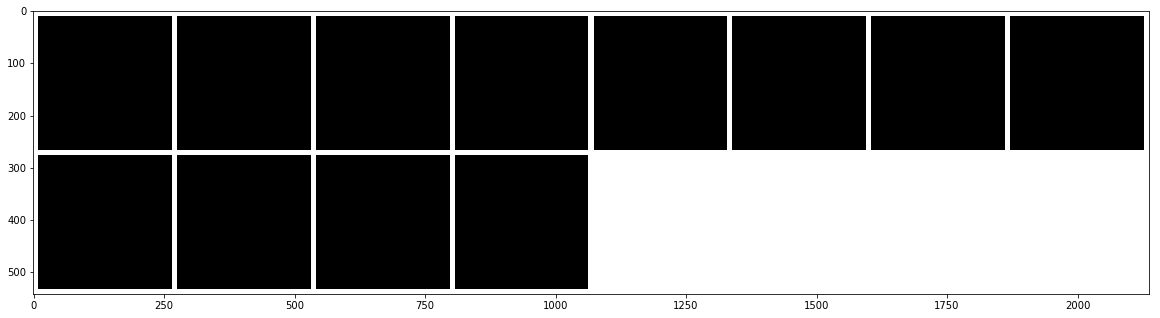

----------------------------------------------------------------------------------------------------
Prediction


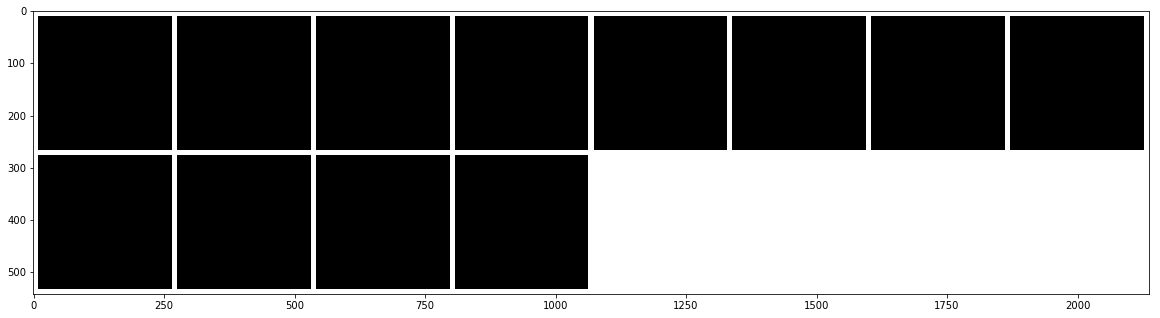

----------------------------------------------------------------------------------------------------
Ground Truth


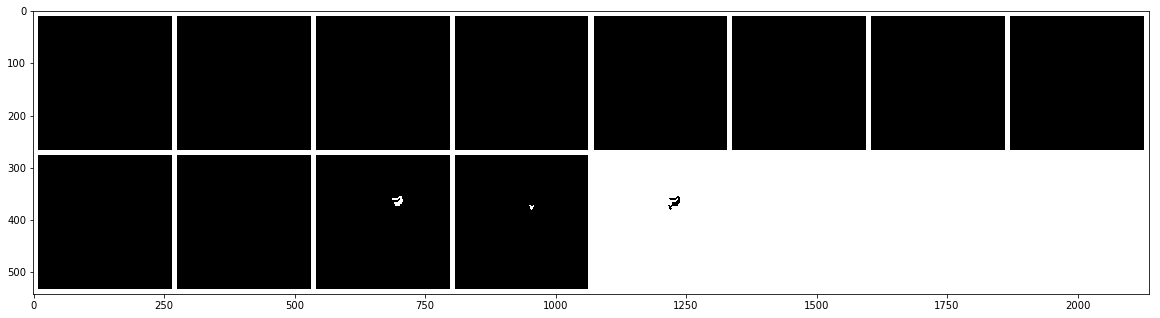

----------------------------------------------------------------------------------------------------
Prediction


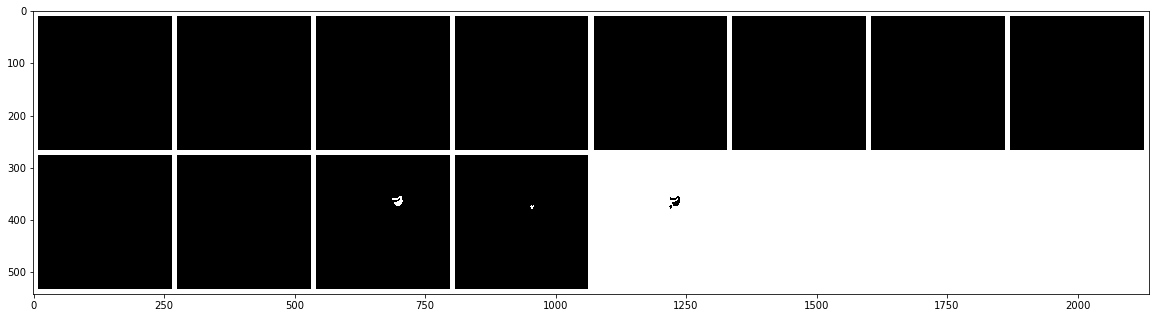

----------------------------------------------------------------------------------------------------
Ground Truth


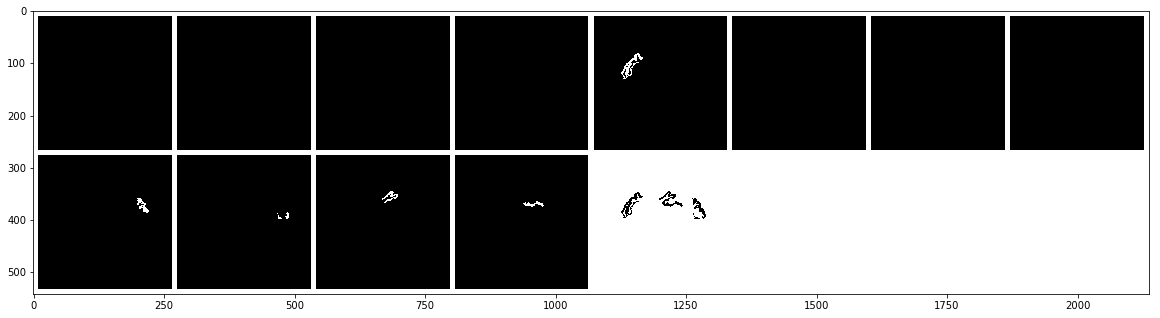

----------------------------------------------------------------------------------------------------
Prediction


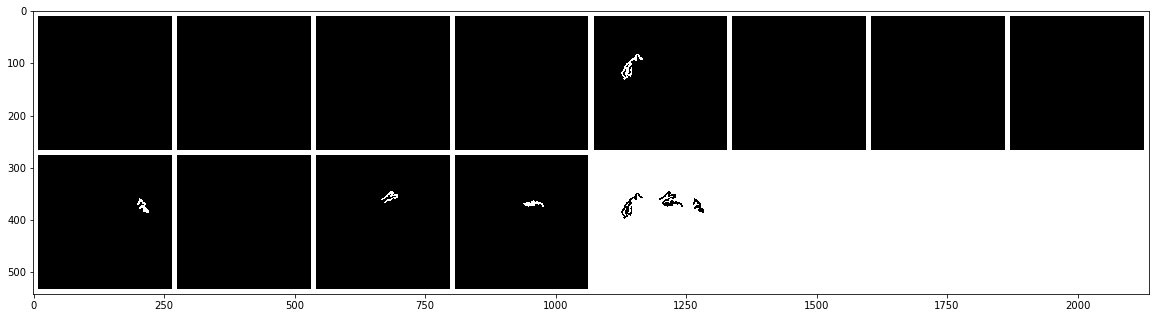

----------------------------------------------------------------------------------------------------
Ground Truth


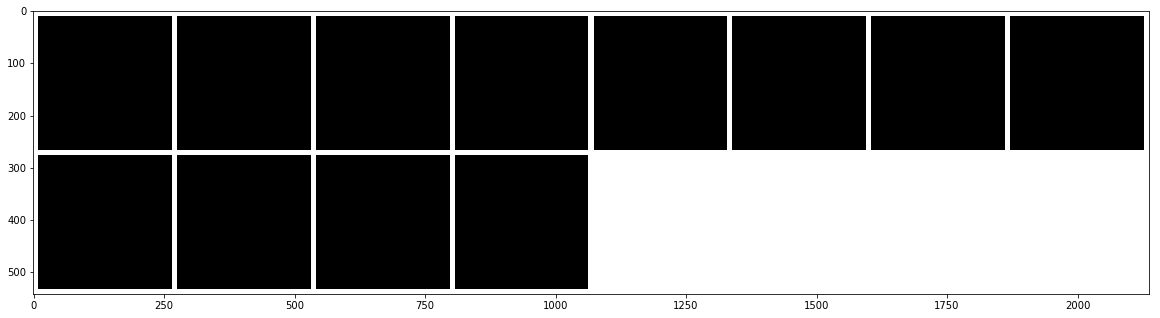

----------------------------------------------------------------------------------------------------
Prediction


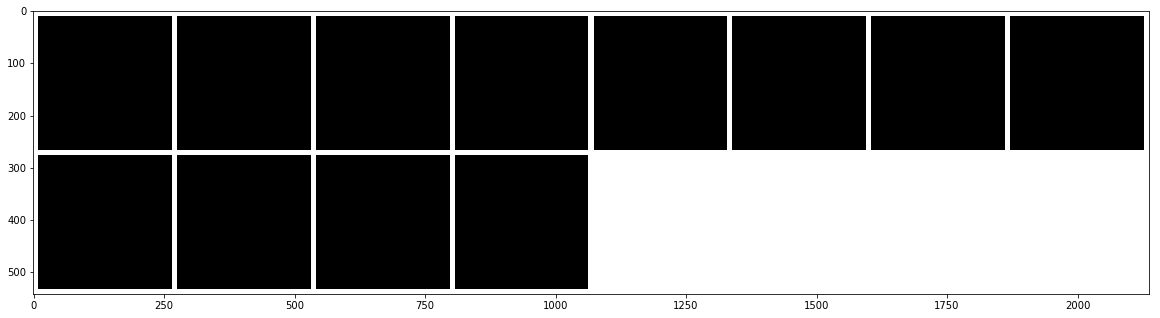

----------------------------------------------------------------------------------------------------
Ground Truth


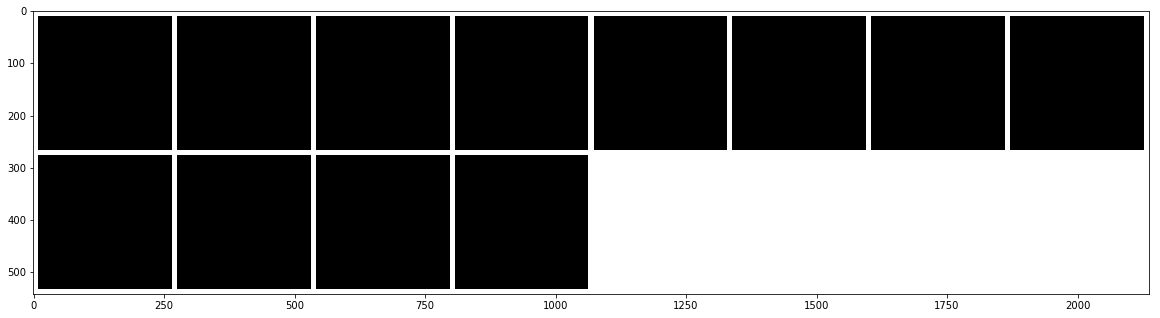

----------------------------------------------------------------------------------------------------
Prediction


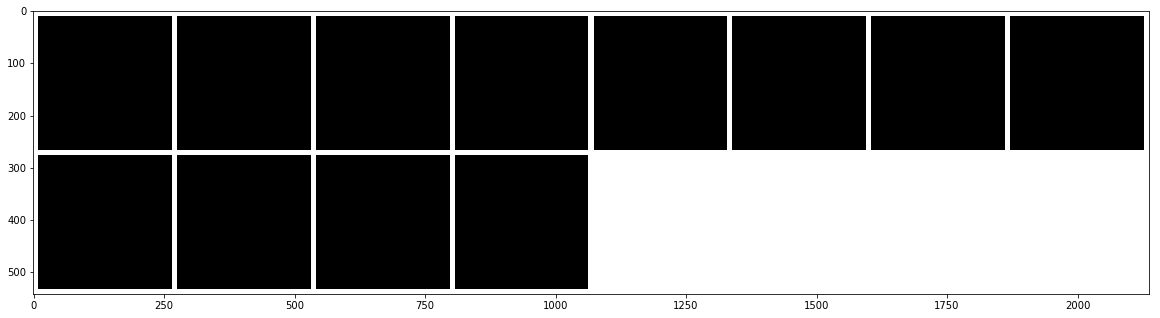

----------------------------------------------------------------------------------------------------
Ground Truth


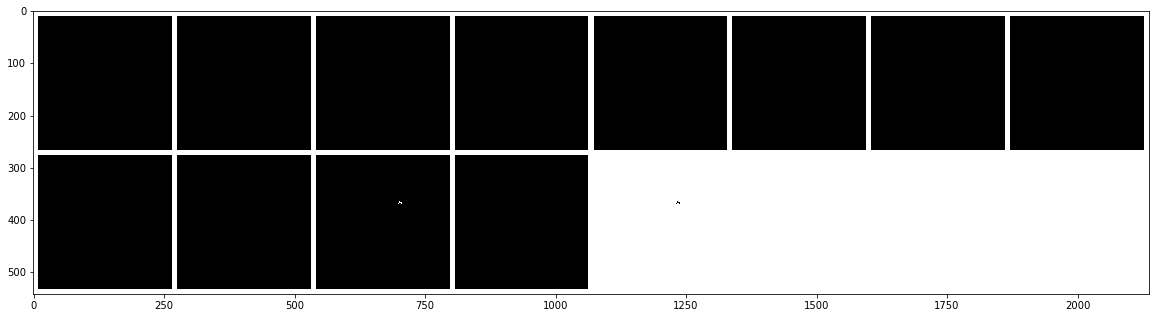

----------------------------------------------------------------------------------------------------
Prediction


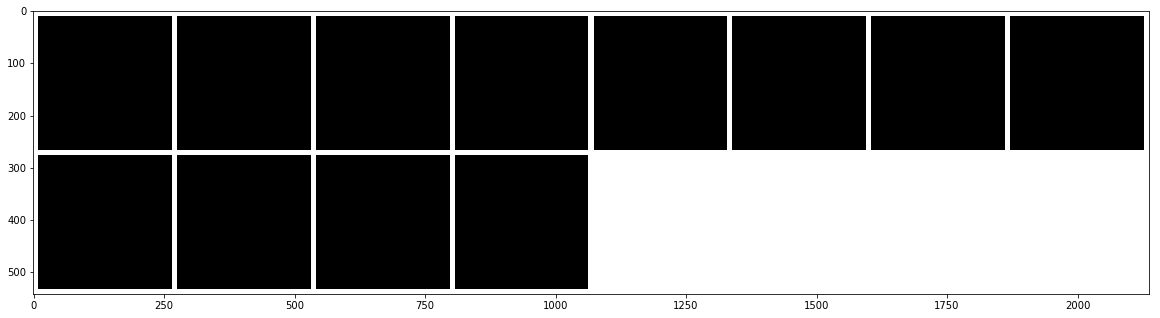

----------------------------------------------------------------------------------------------------
Ground Truth


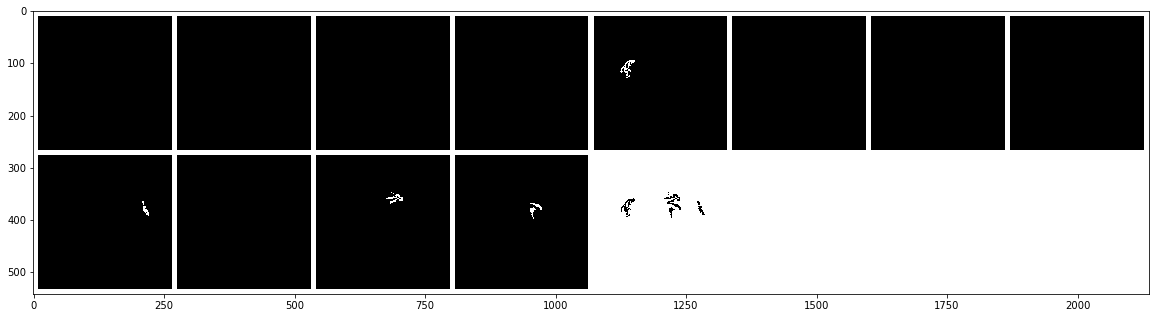

----------------------------------------------------------------------------------------------------
Prediction


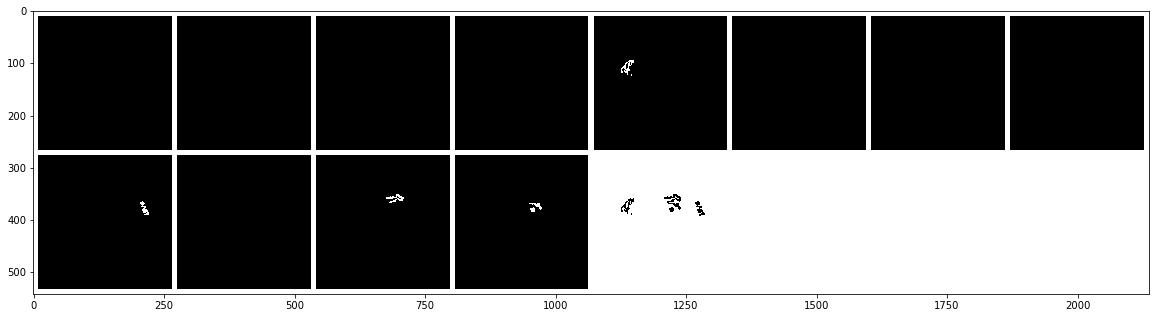

----------------------------------------------------------------------------------------------------
Ground Truth


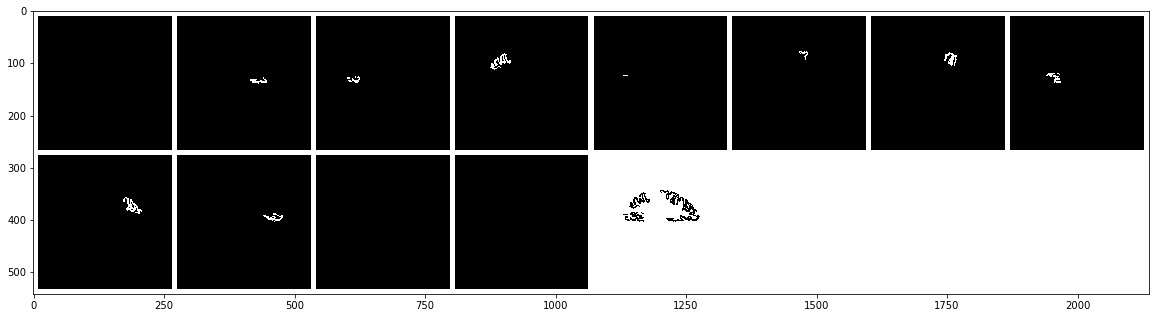

----------------------------------------------------------------------------------------------------
Prediction


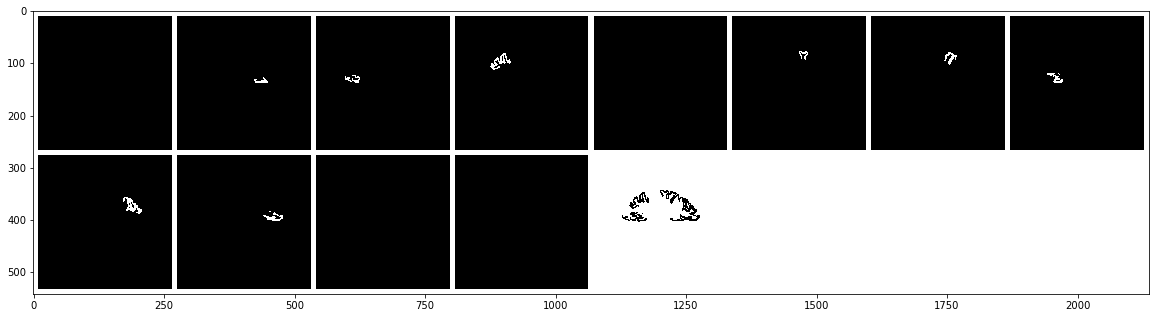

----------------------------------------------------------------------------------------------------
Ground Truth


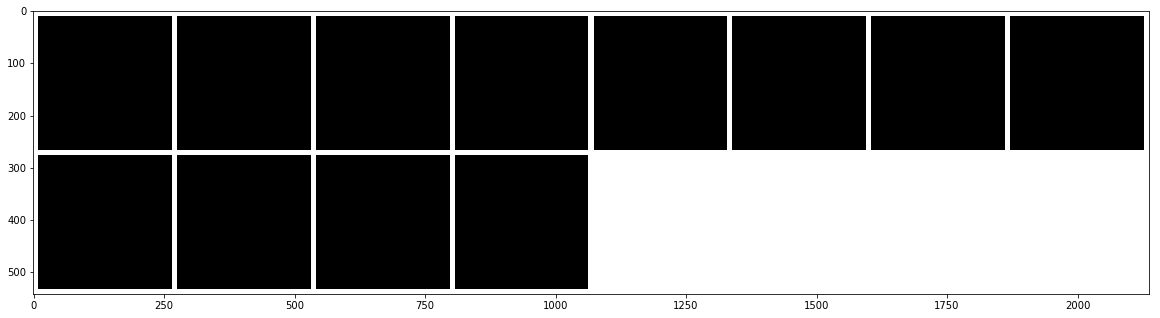

----------------------------------------------------------------------------------------------------
Prediction


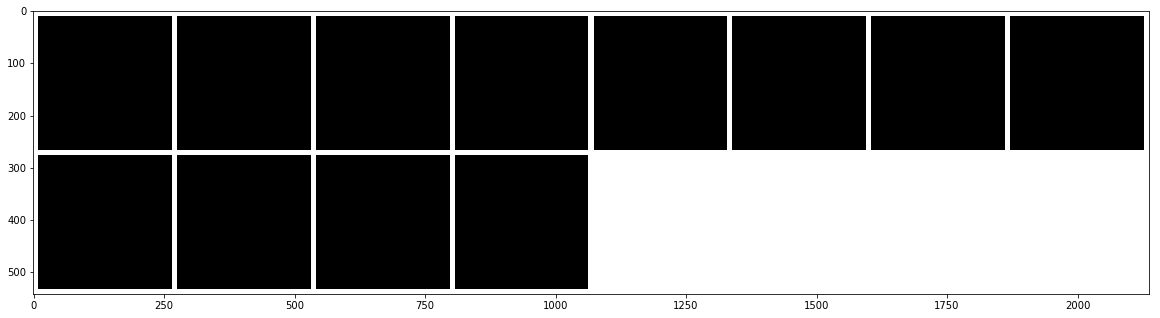

----------------------------------------------------------------------------------------------------
Ground Truth


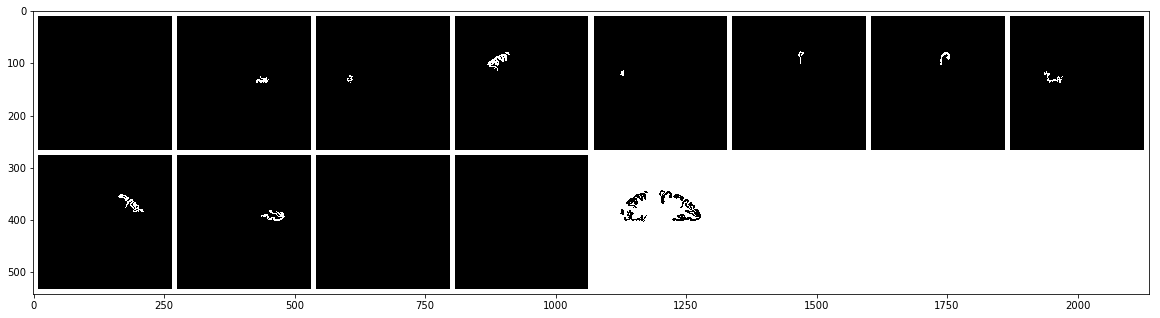

----------------------------------------------------------------------------------------------------
Prediction


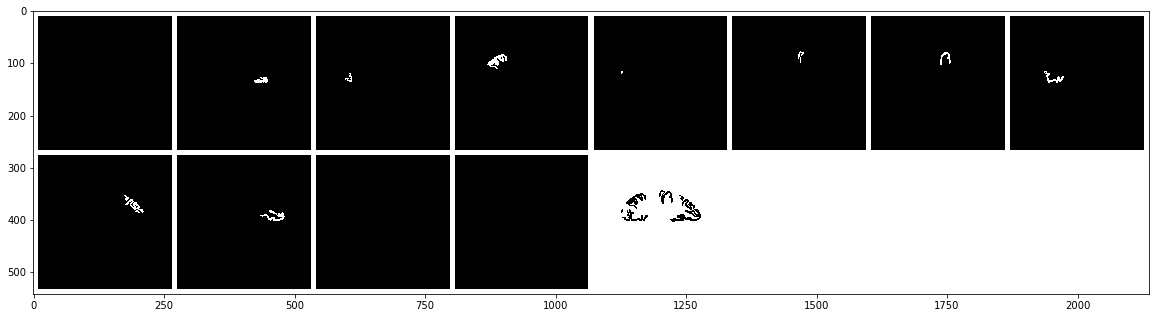

----------------------------------------------------------------------------------------------------
Ground Truth


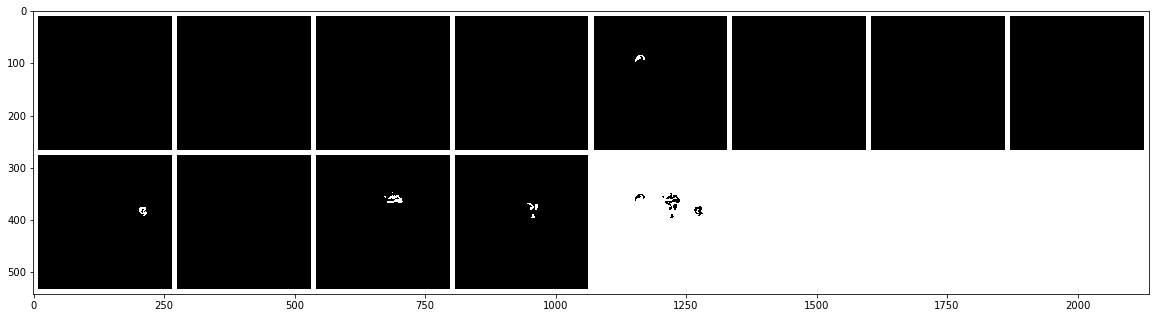

----------------------------------------------------------------------------------------------------
Prediction


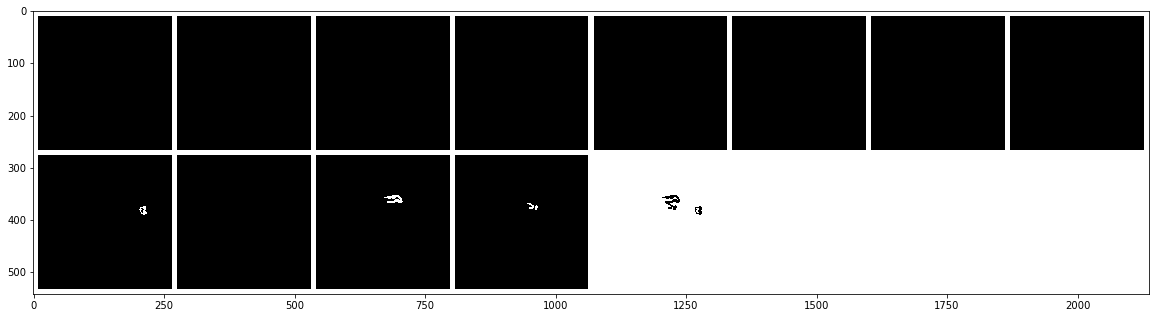

----------------------------------------------------------------------------------------------------
Ground Truth


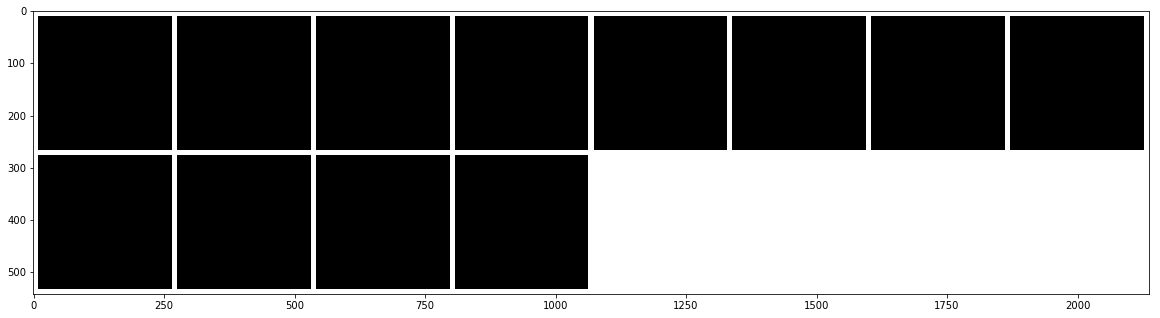

----------------------------------------------------------------------------------------------------
Prediction


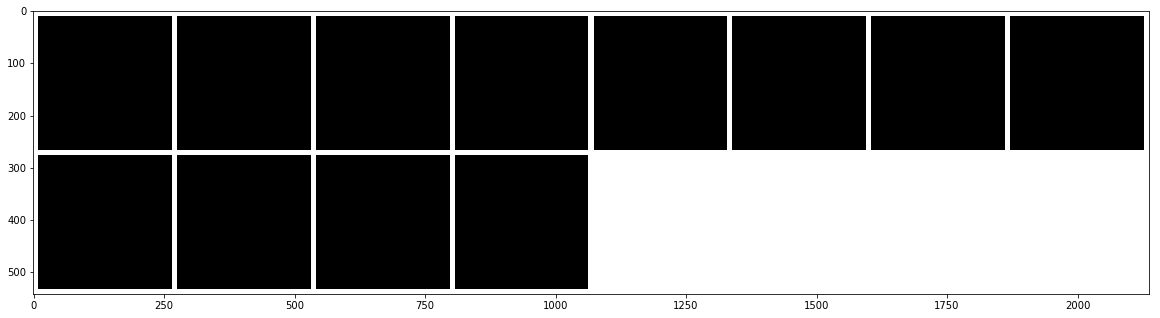

----------------------------------------------------------------------------------------------------
Ground Truth


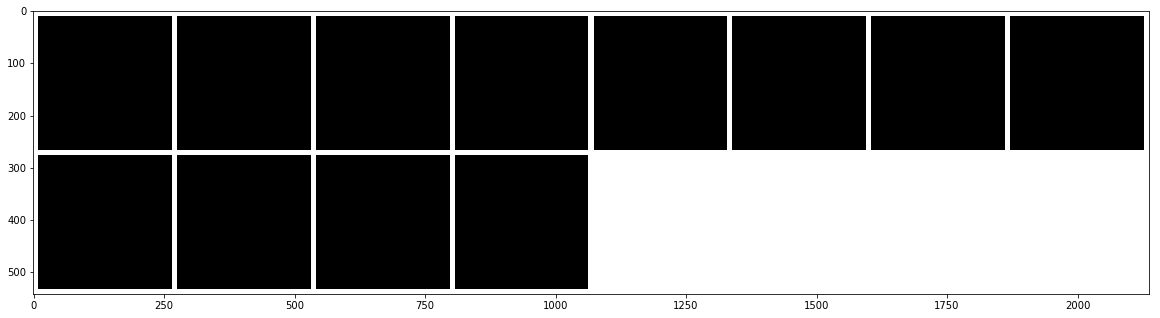

----------------------------------------------------------------------------------------------------
Prediction


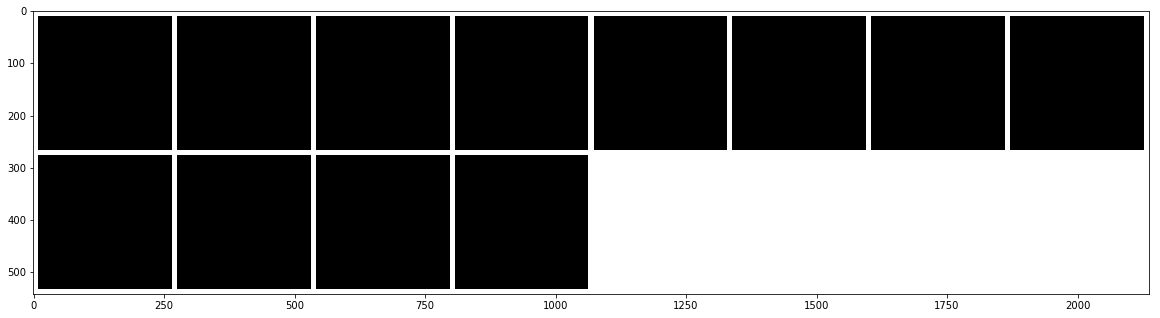

----------------------------------------------------------------------------------------------------
Ground Truth


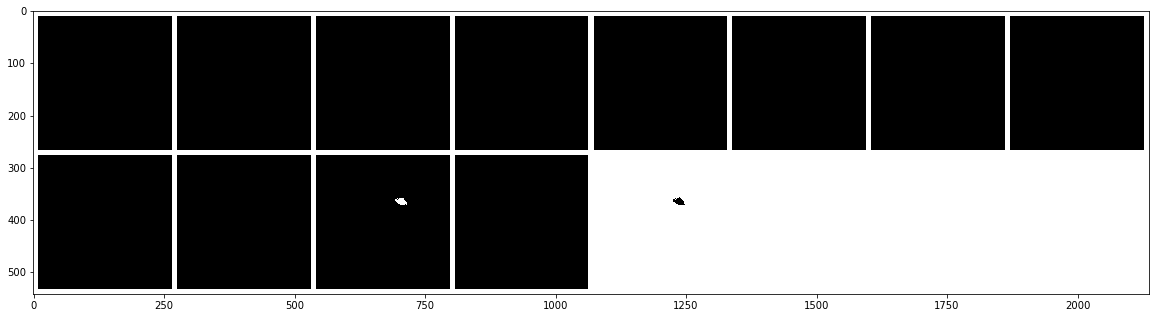

----------------------------------------------------------------------------------------------------
Prediction


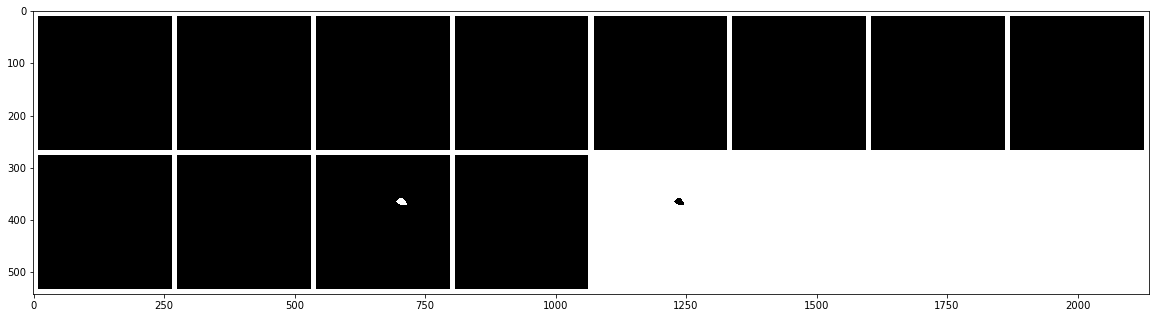

----------------------------------------------------------------------------------------------------
Ground Truth


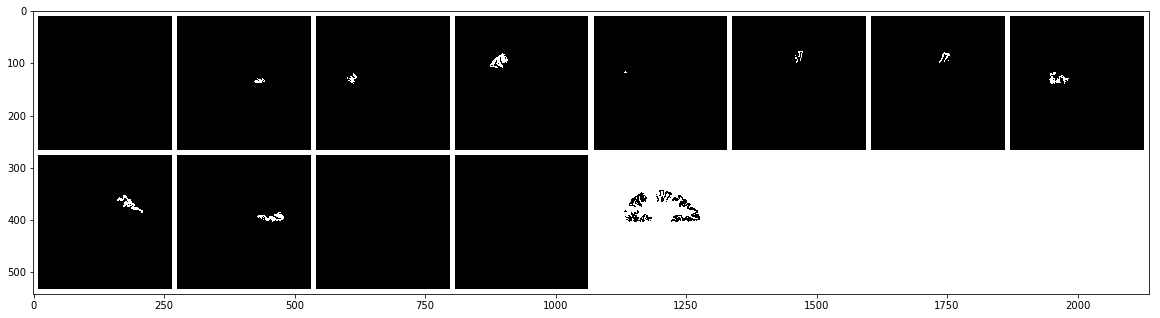

----------------------------------------------------------------------------------------------------
Prediction


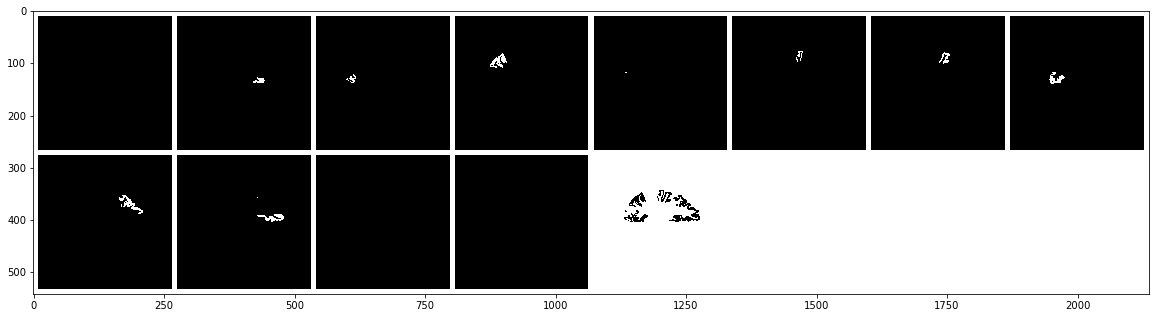

----------------------------------------------------------------------------------------------------
Ground Truth


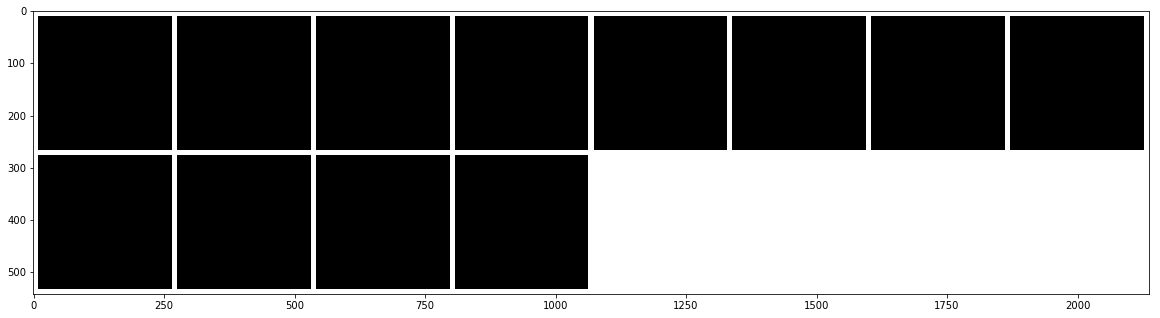

----------------------------------------------------------------------------------------------------
Prediction


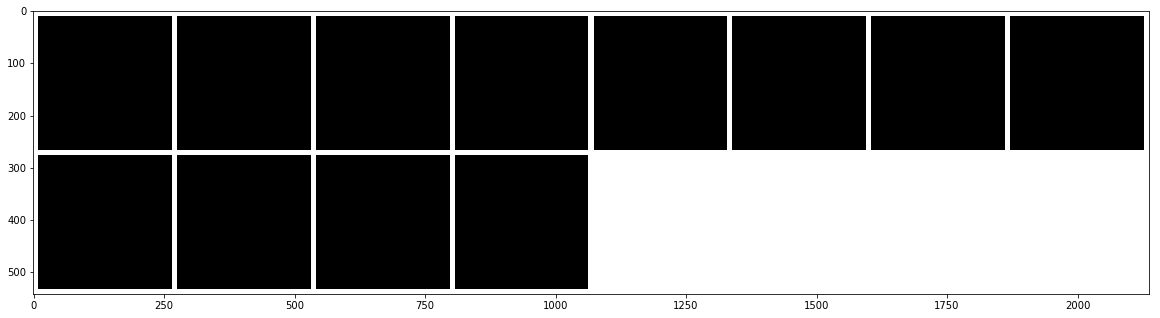

----------------------------------------------------------------------------------------------------
Ground Truth


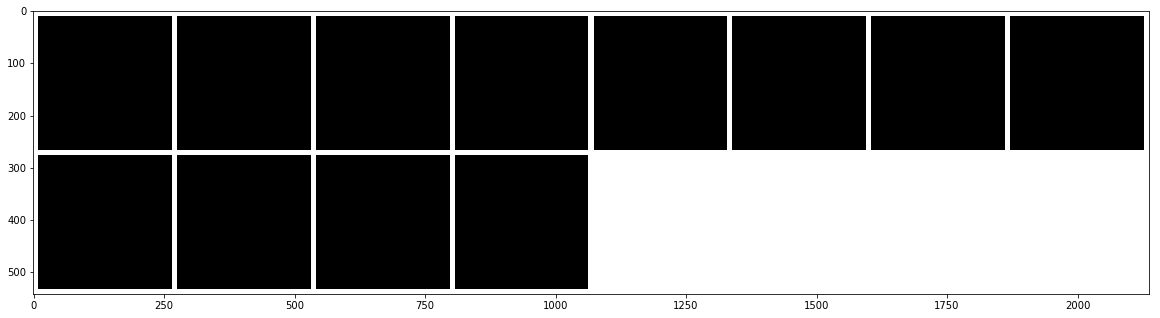

----------------------------------------------------------------------------------------------------
Prediction


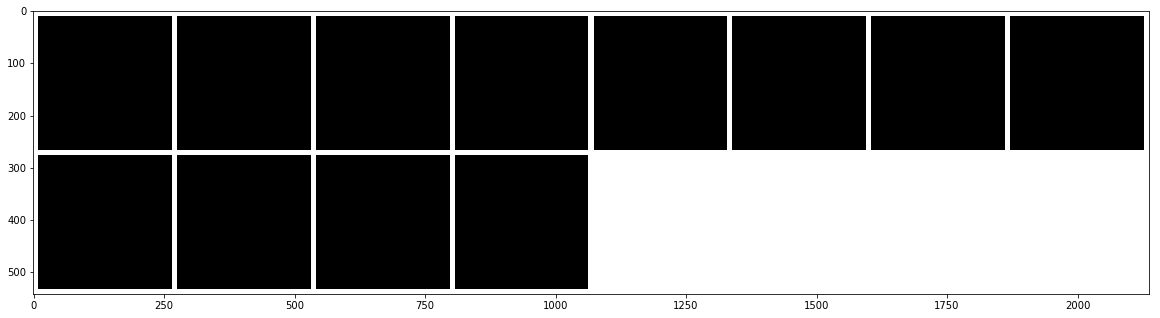

----------------------------------------------------------------------------------------------------
Ground Truth


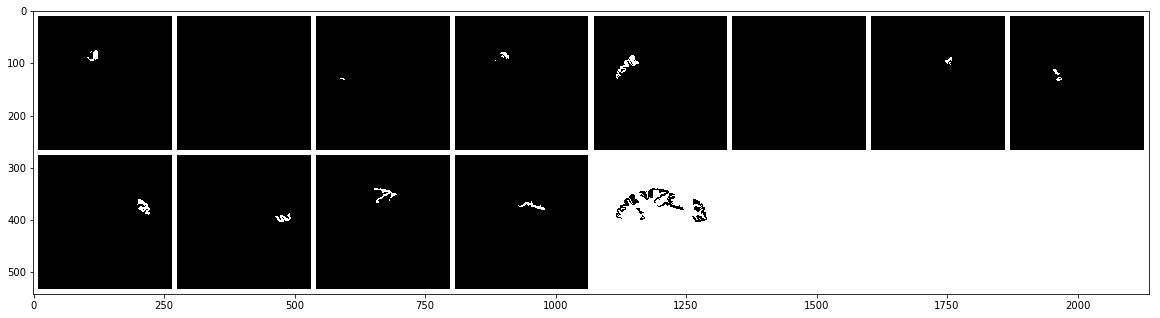

----------------------------------------------------------------------------------------------------
Prediction


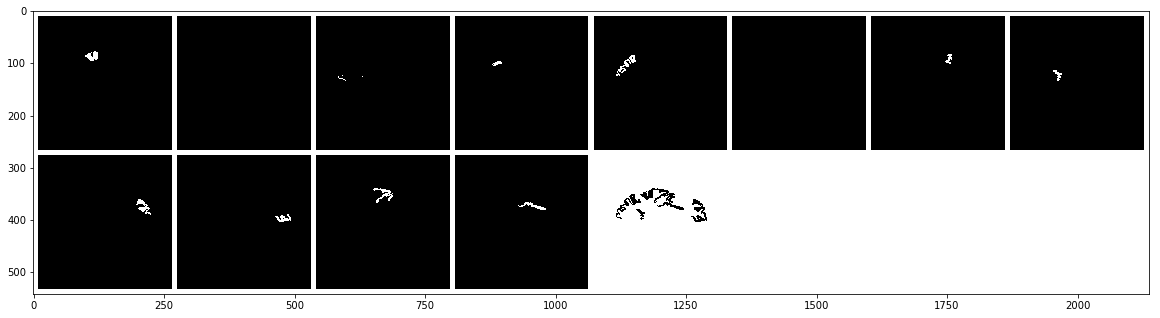

----------------------------------------------------------------------------------------------------
Ground Truth


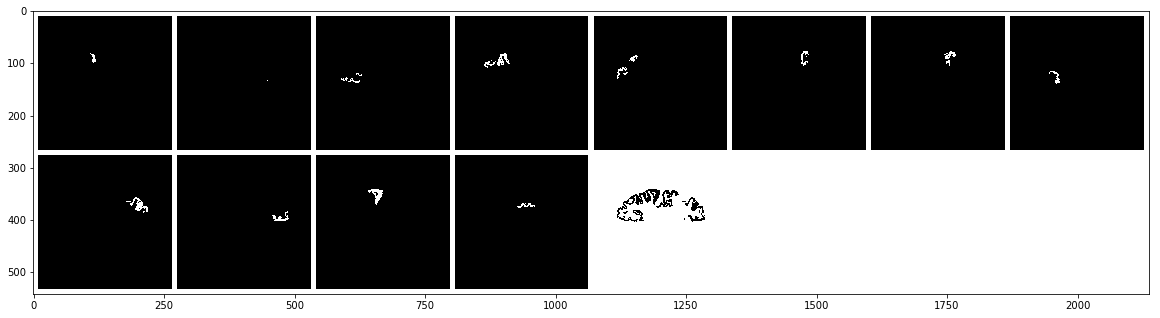

----------------------------------------------------------------------------------------------------
Prediction


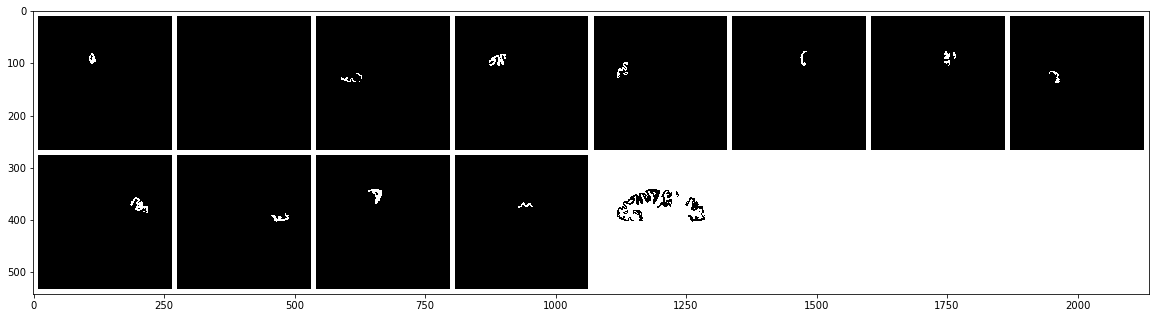

----------------------------------------------------------------------------------------------------
Ground Truth


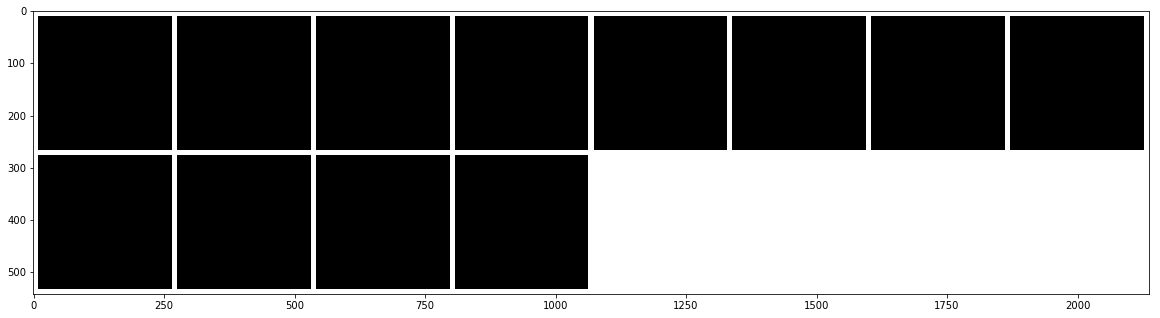

----------------------------------------------------------------------------------------------------
Prediction


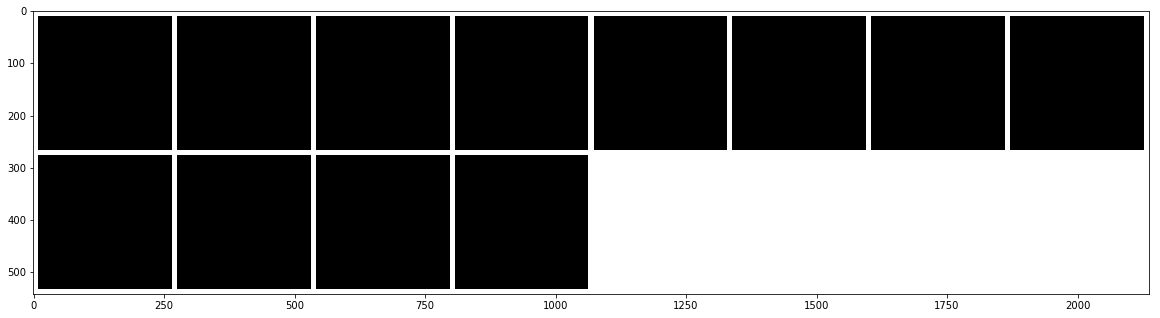

----------------------------------------------------------------------------------------------------
Ground Truth


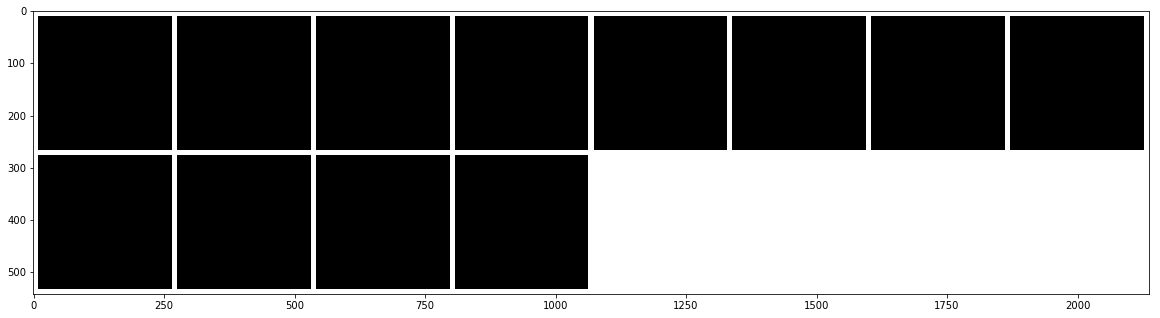

----------------------------------------------------------------------------------------------------
Prediction


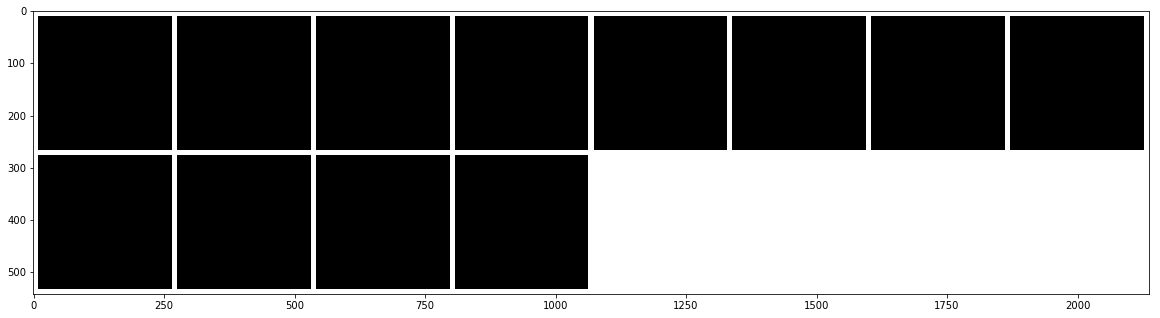

----------------------------------------------------------------------------------------------------
Ground Truth


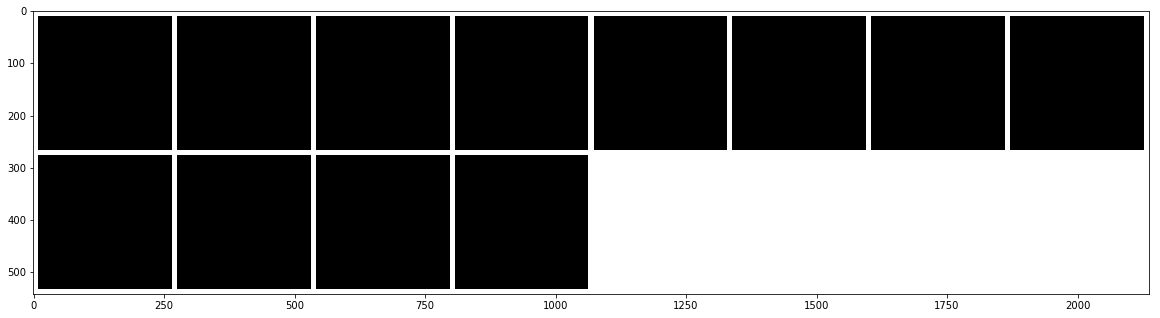

----------------------------------------------------------------------------------------------------
Prediction


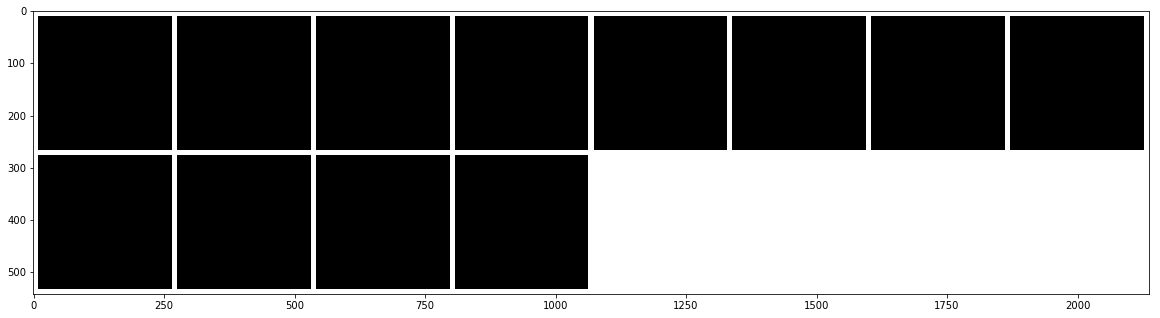

----------------------------------------------------------------------------------------------------
Ground Truth


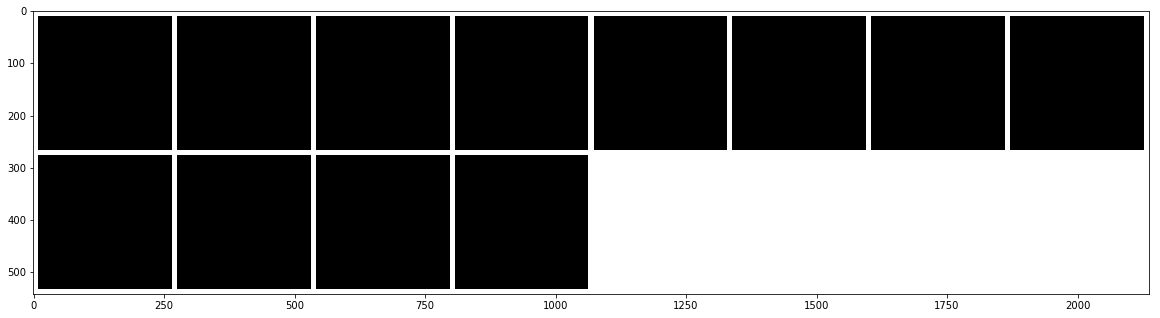

----------------------------------------------------------------------------------------------------
Prediction


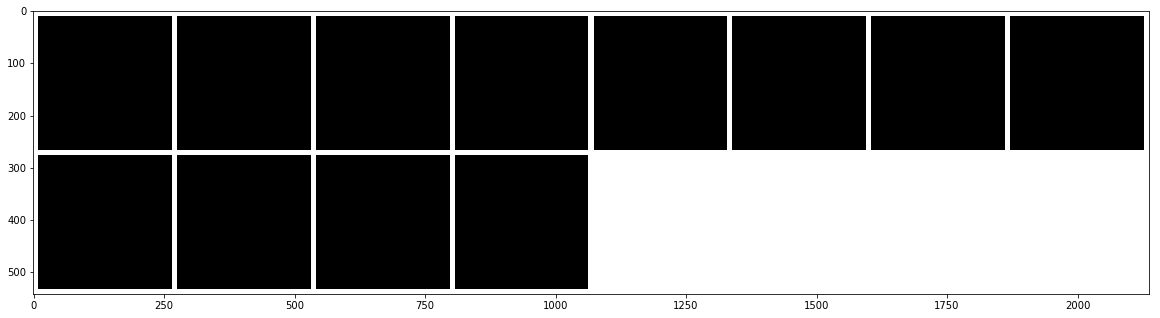

----------------------------------------------------------------------------------------------------
Ground Truth


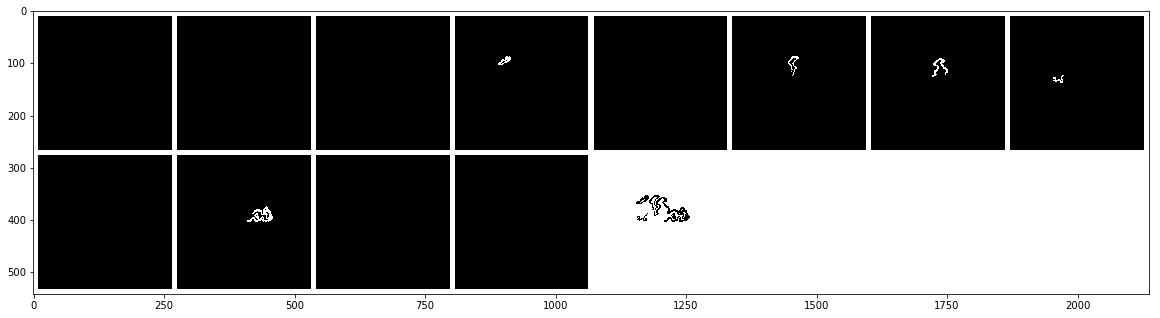

----------------------------------------------------------------------------------------------------
Prediction


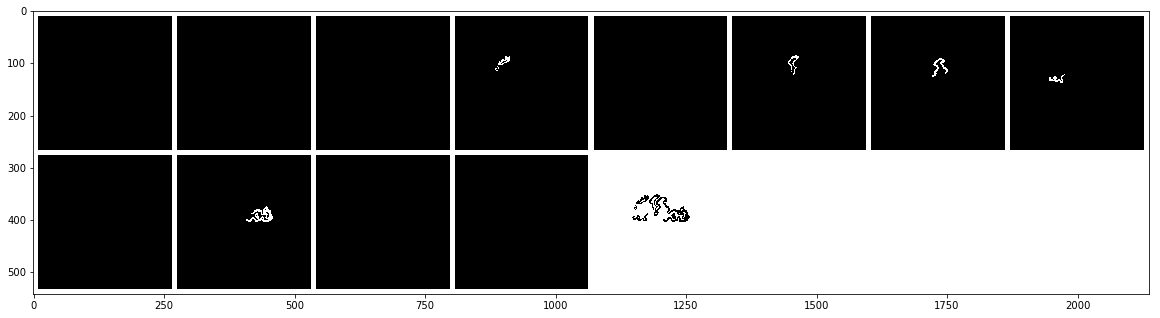

----------------------------------------------------------------------------------------------------
Ground Truth


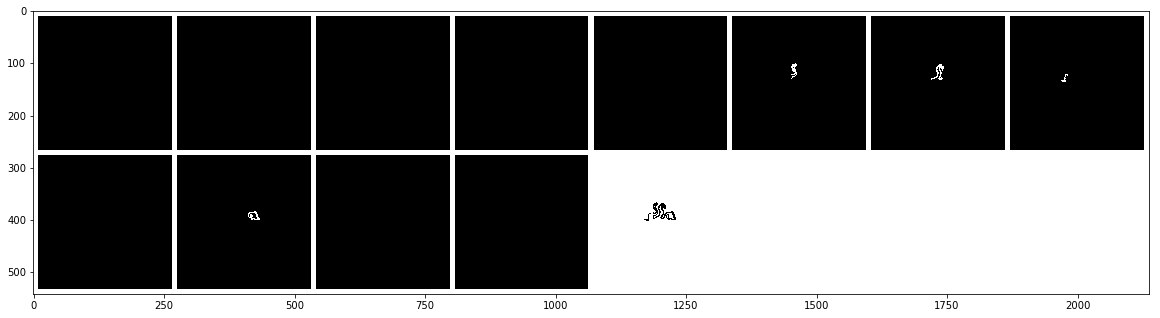

----------------------------------------------------------------------------------------------------
Prediction


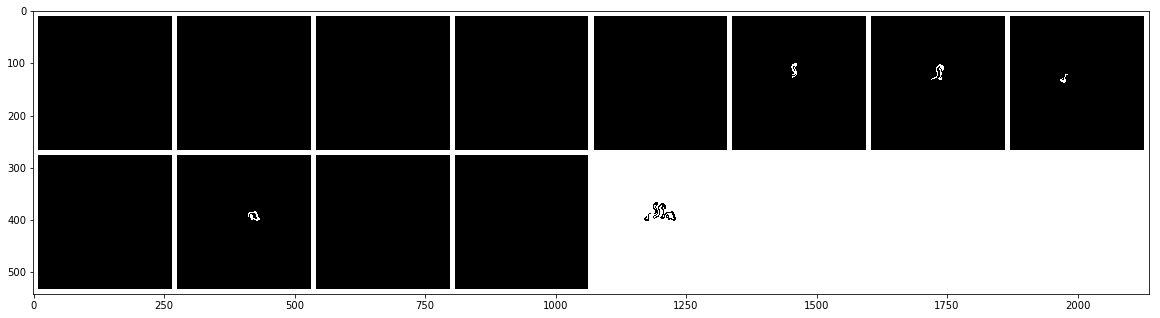

----------------------------------------------------------------------------------------------------
Ground Truth


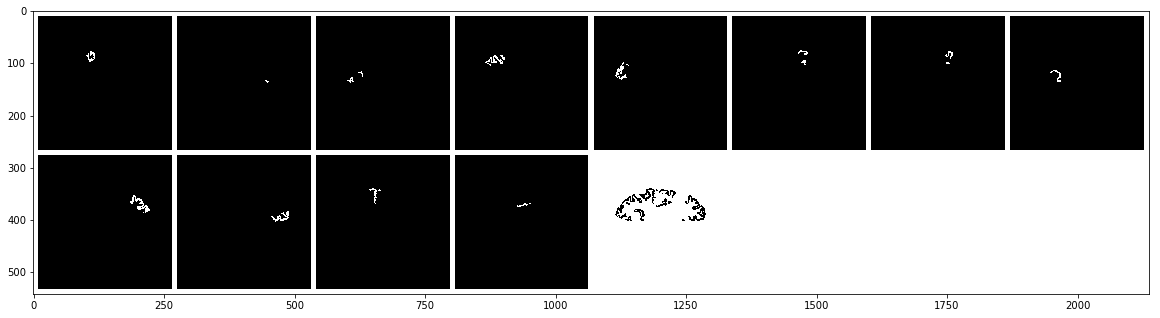

----------------------------------------------------------------------------------------------------
Prediction


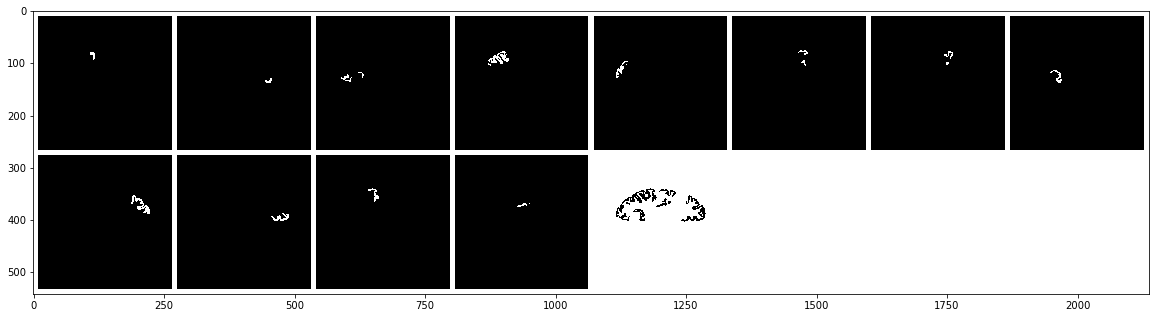

----------------------------------------------------------------------------------------------------
Ground Truth


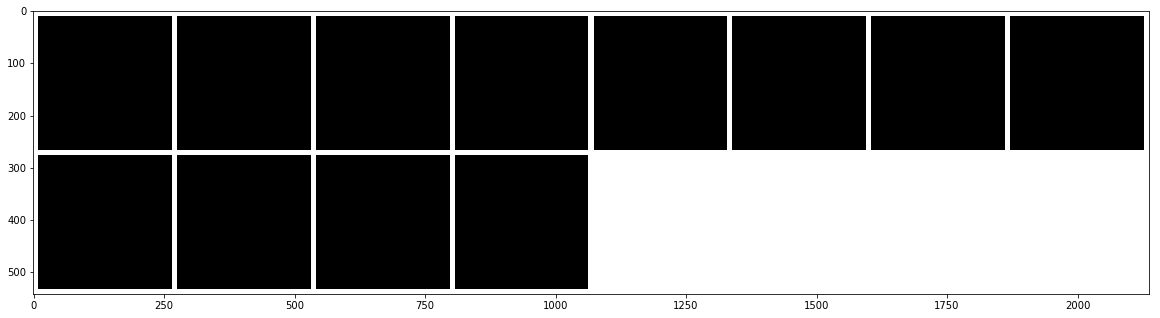

----------------------------------------------------------------------------------------------------
Prediction


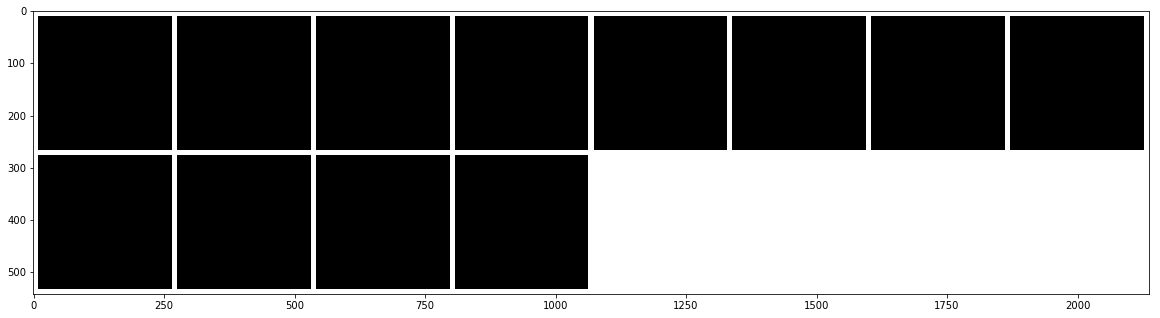

----------------------------------------------------------------------------------------------------
Ground Truth


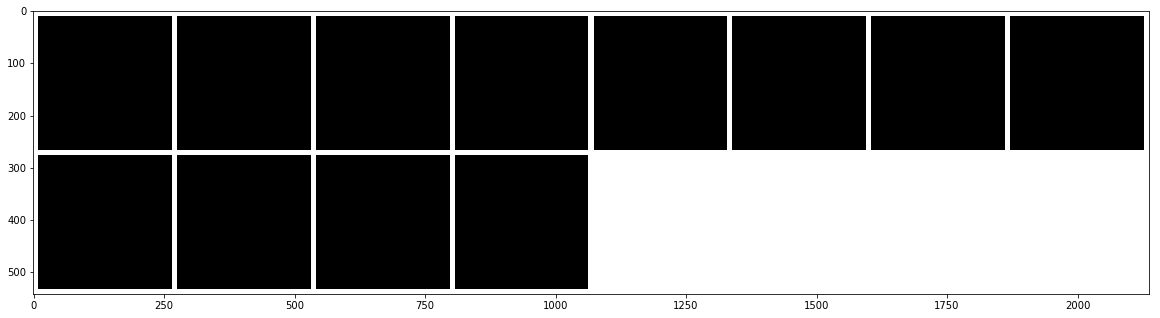

----------------------------------------------------------------------------------------------------
Prediction


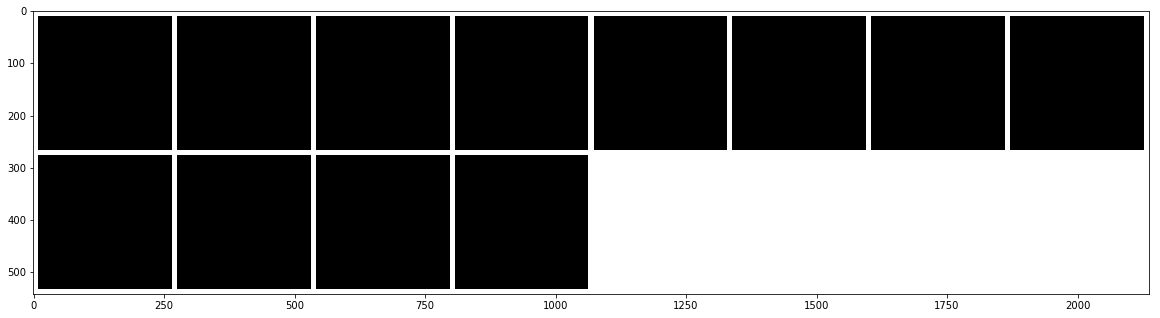

----------------------------------------------------------------------------------------------------
Ground Truth


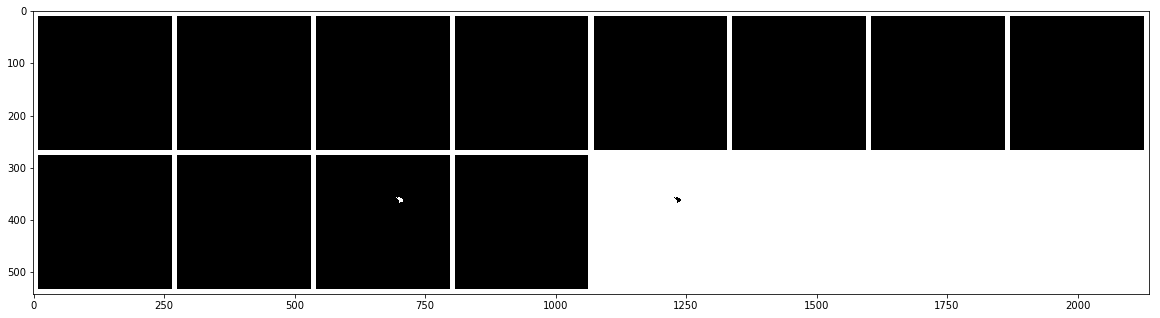

----------------------------------------------------------------------------------------------------
Prediction


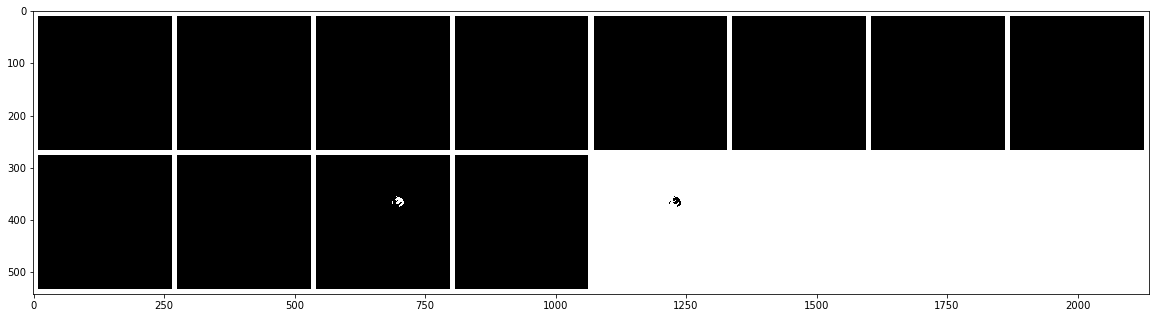

----------------------------------------------------------------------------------------------------
Ground Truth


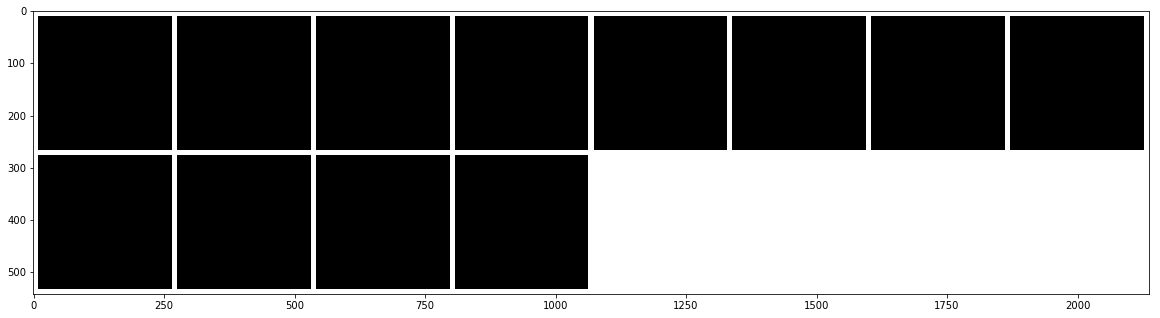

----------------------------------------------------------------------------------------------------
Prediction


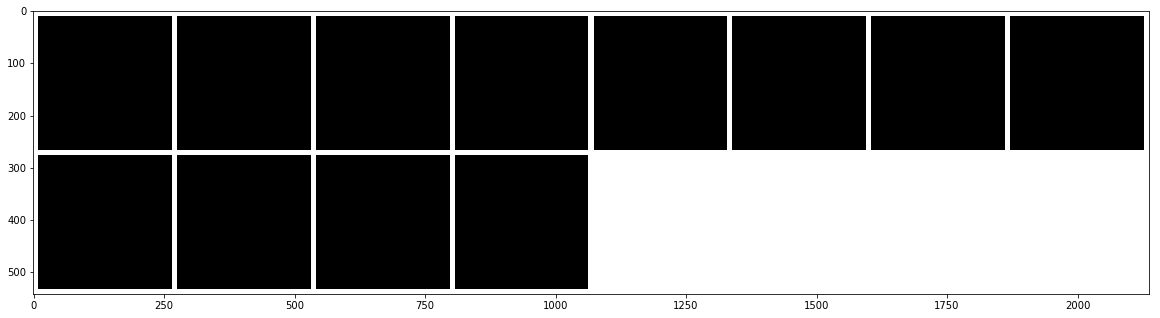

----------------------------------------------------------------------------------------------------
Ground Truth


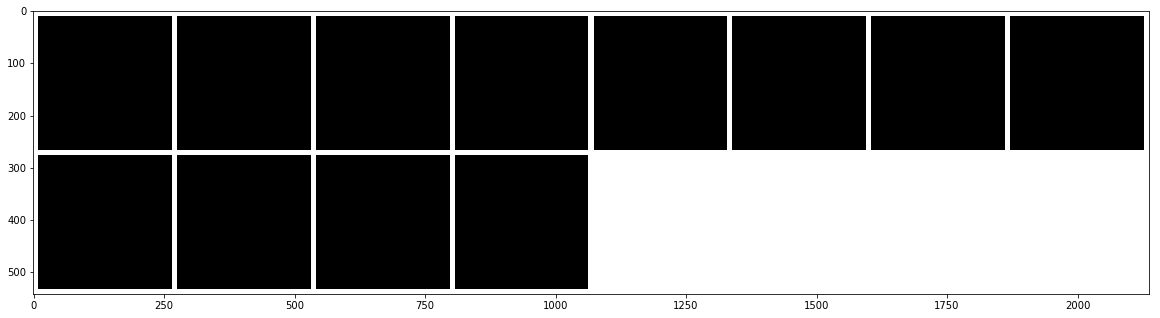

----------------------------------------------------------------------------------------------------
Prediction


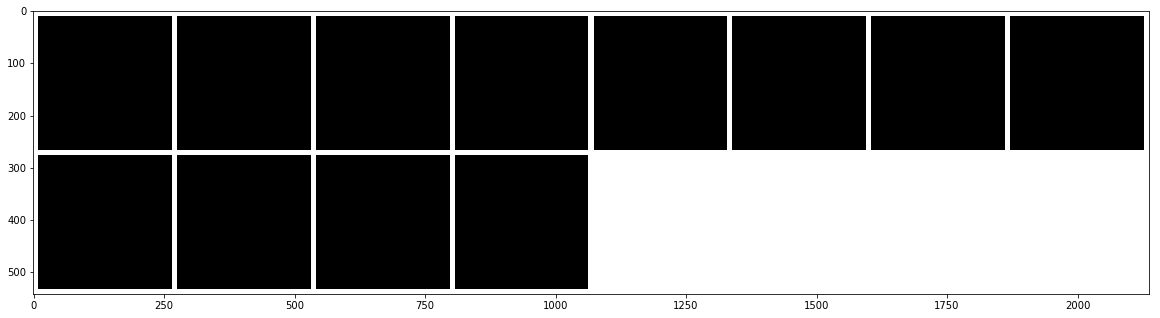

----------------------------------------------------------------------------------------------------
Ground Truth


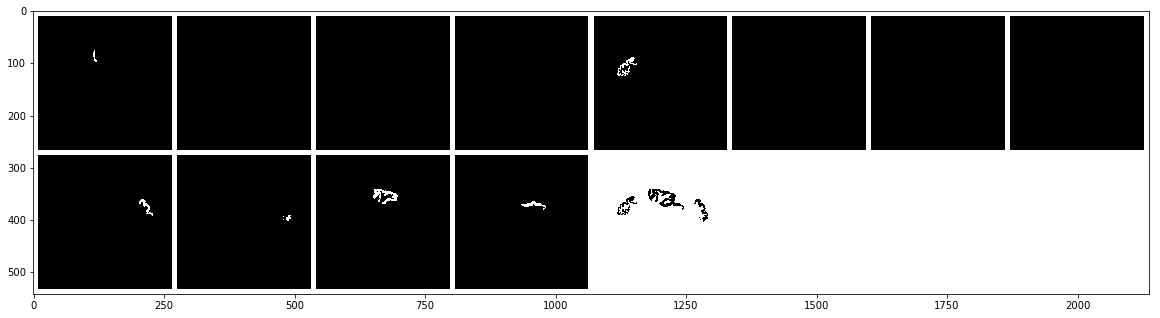

----------------------------------------------------------------------------------------------------
Prediction


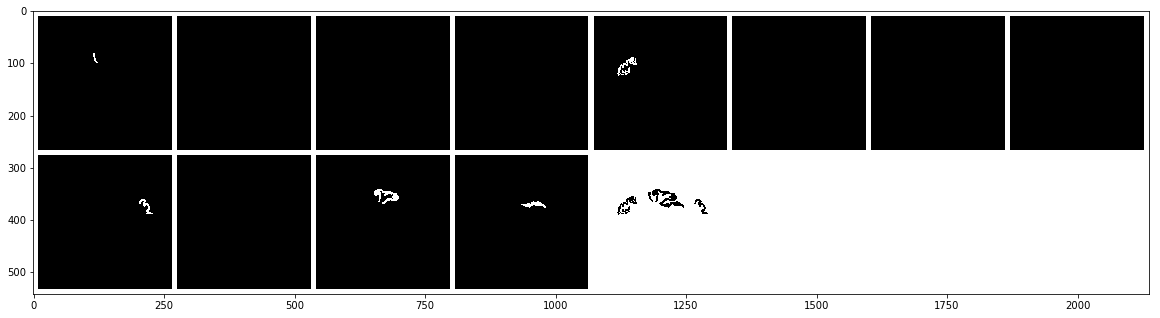

----------------------------------------------------------------------------------------------------
Ground Truth


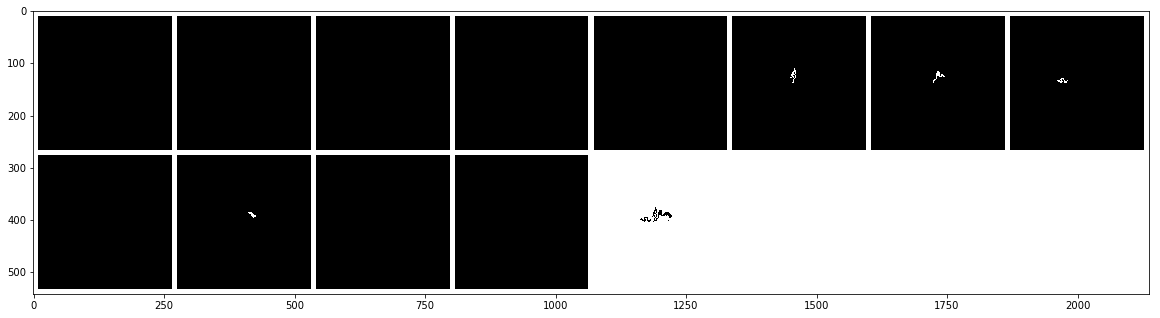

----------------------------------------------------------------------------------------------------
Prediction


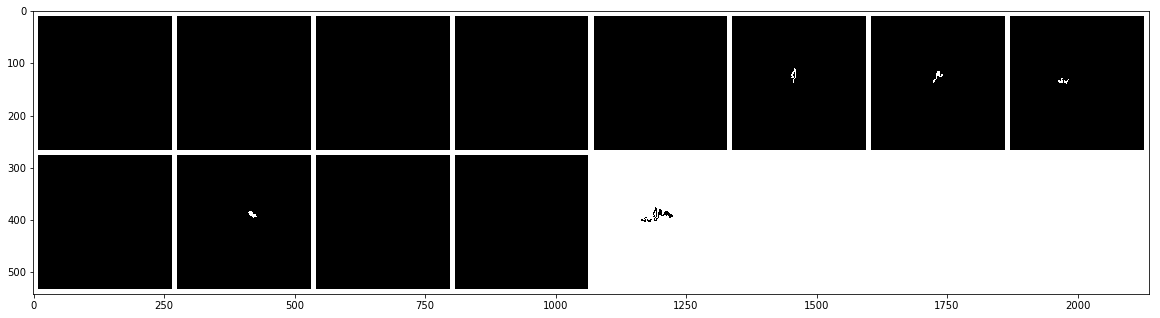

----------------------------------------------------------------------------------------------------
Ground Truth


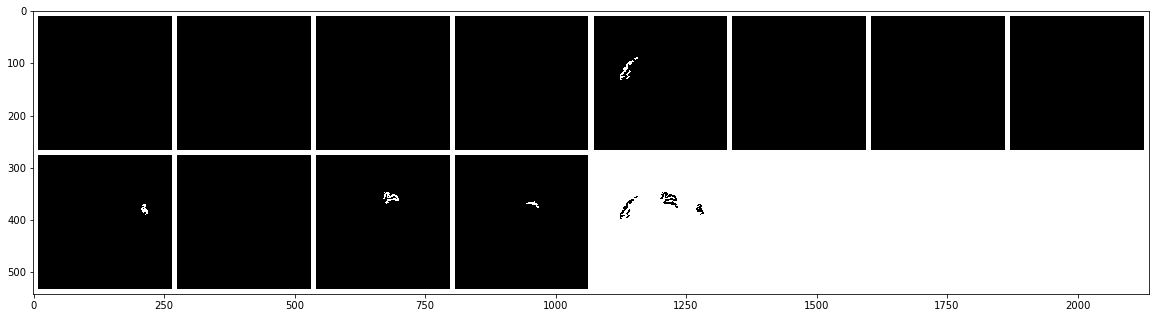

----------------------------------------------------------------------------------------------------
Prediction


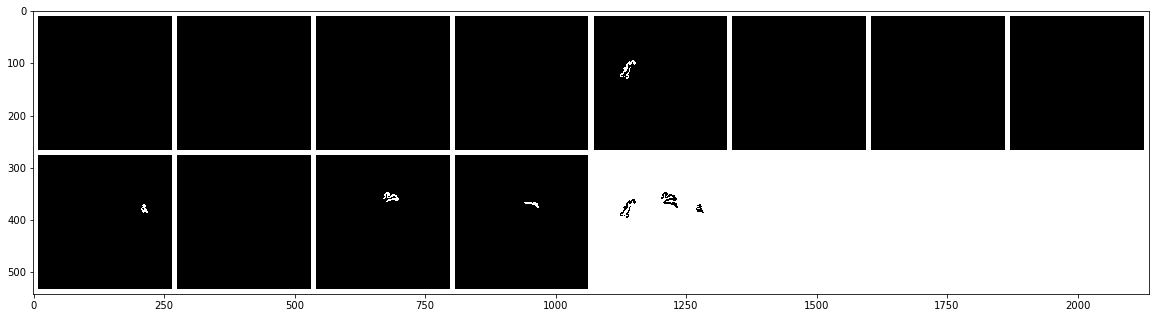

----------------------------------------------------------------------------------------------------
Ground Truth


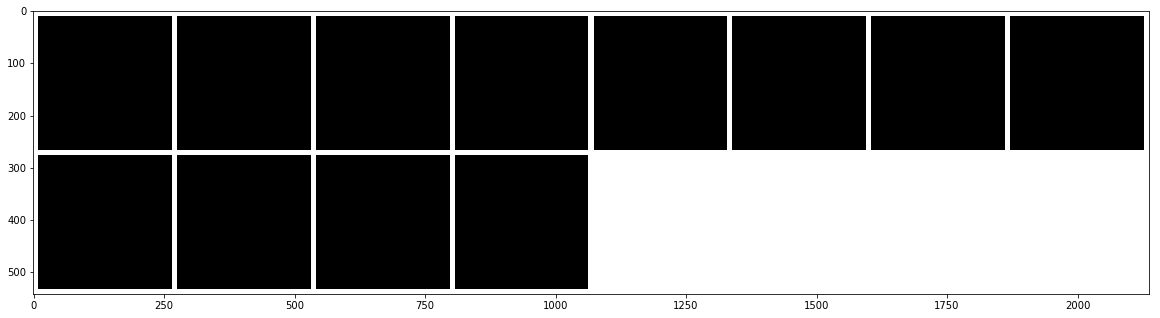

----------------------------------------------------------------------------------------------------
Prediction


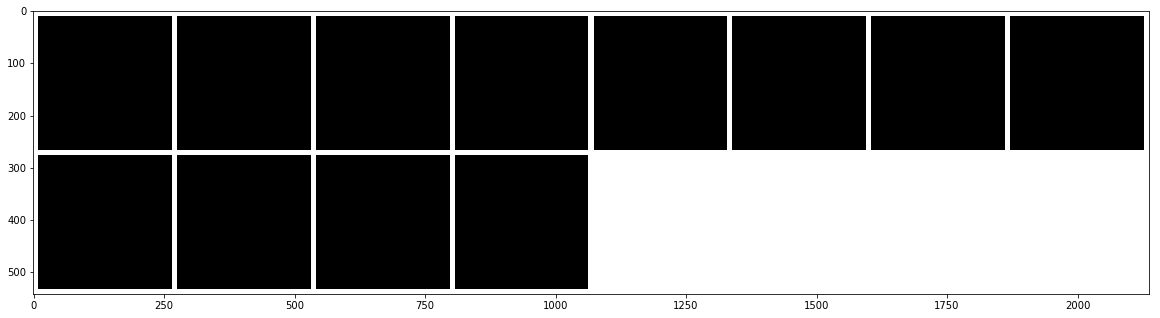

----------------------------------------------------------------------------------------------------
Ground Truth


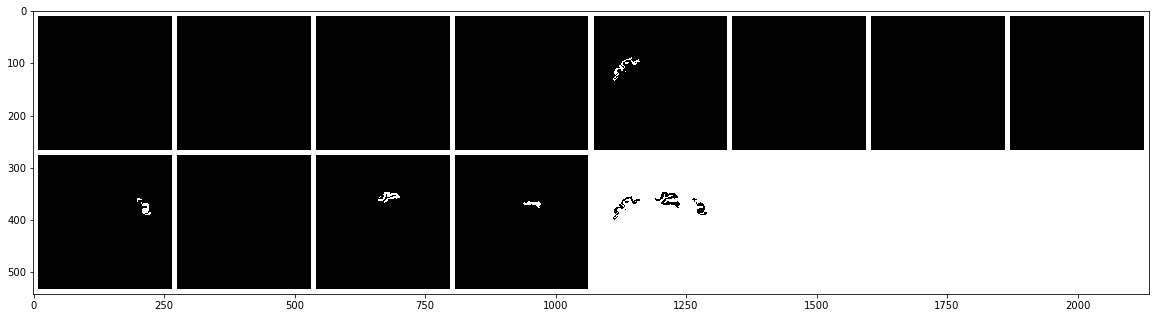

----------------------------------------------------------------------------------------------------
Prediction


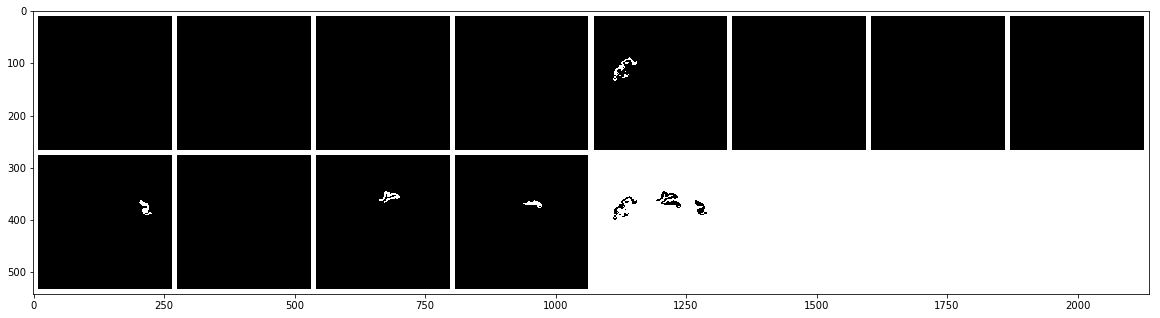

----------------------------------------------------------------------------------------------------
Ground Truth


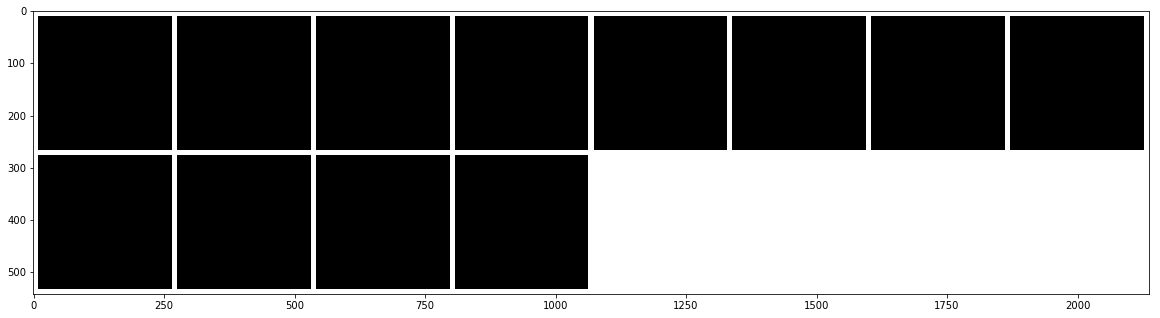

----------------------------------------------------------------------------------------------------
Prediction


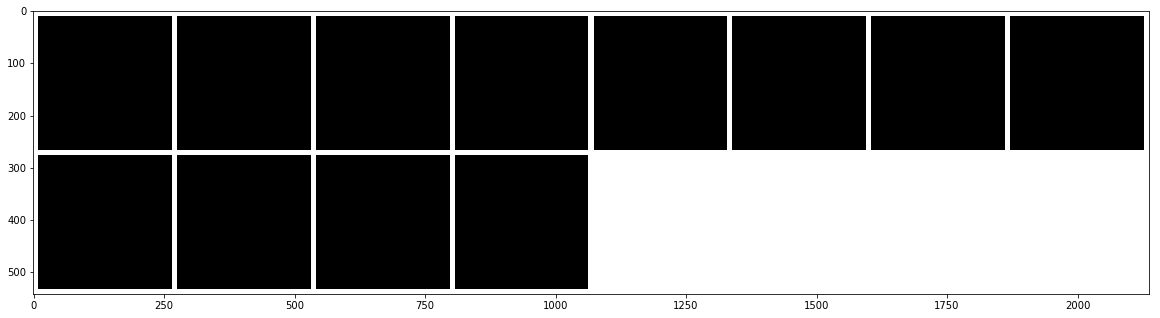

----------------------------------------------------------------------------------------------------
Ground Truth


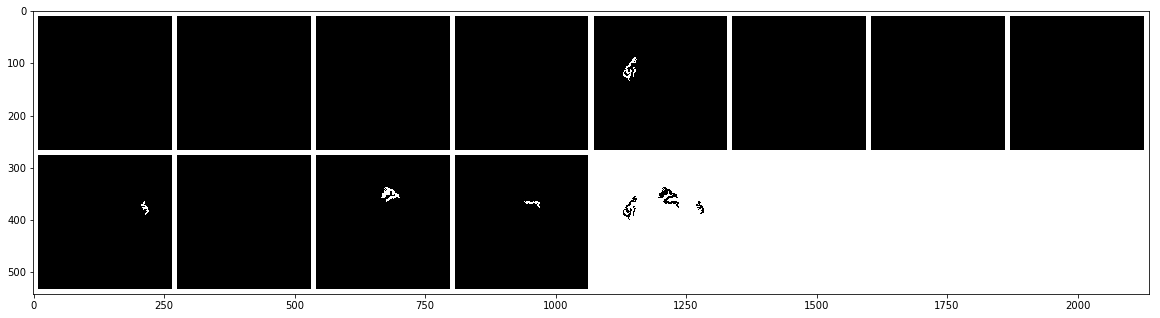

----------------------------------------------------------------------------------------------------
Prediction


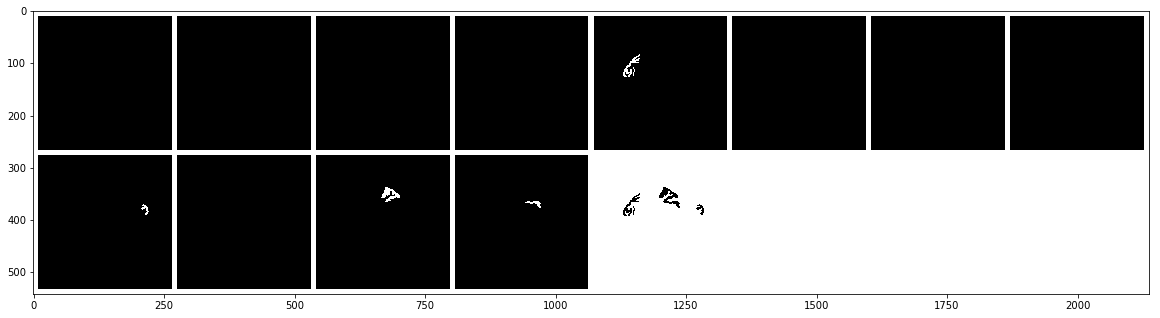

In [57]:
visualize_few()

In [64]:
# loss_hist = unpickling('Loss_hist_29_seg_1.p')

In [65]:
# loss_hist